In this notebook we explore more about eye tracking data analysis

In [237]:
# Derived from:
#     https://www.axonlab.org/hcph-sops/data-management/eyetrack-qc
# Load the autoreload extension
%load_ext autoreload
# Set autoreload to update the modules every time before executing a new line of code
%autoreload 2

%matplotlib inline
from pathlib import Path
import json
import ppjson
from importlib import reload  # For debugging purposes

import numpy as np
import pandas as pd

import eyetrackingrun as et

from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import copy
from write_bids_yiwei import EyeTrackingRun, write_bids, write_bids_from_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [238]:
subject_idx = 2
T_idx = 1

if T_idx == 1:
    mode = 'T1'
else:
    mode = 'T2'

if subject_idx == 1:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub001\\230928_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"JB{T_idx}"    
elif subject_idx == 2:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub002\\230926_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"BF_T{T_idx}" 
elif subject_idx == 3:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub003\\230928_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"OT{2*T_idx}"
    # "OT4.EDF"
else:
    BIDS_PATH = Path("C:\\yiwei\\1_Pilot_MREye_Data\\Sub004\\230923_anatomical_MREYE_study\\ET_EDF")
    FILE_NAME = f"HV{T_idx}"
    
# D:\Eye_Dataset\Sub001\230928_anatomical_MREYE_study\ET_EDF
session = "001" #can be a string to be defined when required
tsv_name = f"{FILE_NAME}.tsv.gz"
gif_name = f'{FILE_NAME}.gif'


In [239]:
# Read in tsv.gz file
# Naming convension can be modified later
# recording_file = BIDS_PATH / "sub-001" / f"ses-{session}" / "dwi" / f"sub-001_ses-{session}_acq-highres_dir-RL_recording-eyetrack_physio.tsv.gz"
recording_file = BIDS_PATH / tsv_name
print(f'recording_file: {recording_file}')
recording = pd.read_csv(
    recording_file,
#     sep=r"\s+",
    sep="\t",
    na_values="n/a",
)
recording.head()
print(f'recording len: {len(recording)}')
metadata = json.loads((
    recording_file.parent
    / recording_file.name.replace(".tsv.gz", ".json")
).read_text())
print(f'meta_data: {metadata}')

print('The duration of sub001 t1: 374557.5 ms -> 374558 ms')
print('The duration of sub002 t1: 374380 ms')

recording_file: C:\yiwei\1_Pilot_MREye_Data\Sub002\230926_anatomical_MREYE_study\ET_EDF\BF_T1.tsv.gz
recording len: 720576
meta_data: {'AverageCalibrationError': [0.84], 'CalibrationCount': 1, 'CalibrationLog': [[2897461, '>>>>>>> CALIBRATION (HV5,P-CR) FOR RIGHT: <<<<<<<<<'], [2897462, 'Calibration points:'], [2897462, '-27.0, -65.7         0,      0'], [2897462, '-25.4, -88.8         0,  -2457'], [2897462, '-30.1, -44.3         0,   2457'], [2897462, '-66.9, -63.9     -3474,      0'], [2897462, '-25.7, -63.1      3474,      0'], [2897462, 'eye check box: (L,R,T,B)\n\t  -71   -21   -93   -40'], [2897462, 'href cal range: (L,R,T,B)\n\t-5211  5211 -3686  3686'], [2897462, 'Cal coeff:(X=a+bx+cy+dxx+eyy,Y=f+gx+goaly+ixx+jyy)\n   5.882e-05  2108.2  215.51  50.438  2.8157 \n   4.4115e-05 -173.98  92.93 -4.4697 -0.037811'], [2897462, 'Prenormalize: offx, offy = -27.036 -65.685'], [2897462, 'Gains: cx:2965.506 lx:446.410 rx:5484.733'], [2897462, 'Gains: cy:590.000 ty:234.457 by:523.847'], [28

# Metadata and calibration

We always run a calibration before it is started. As a result, we will typically see the metadata corresponding to calibration on this particular run.

Now, let's print out the contents of the BIDS' sidecar JSON corresponding to the DWI in this session.

In [240]:
recording

,Unnamed: 0,eye1_x_coordinate,eye1_y_coordinate,eye1_pupil_size,eye1_pupil_x_coordinate,eye1_pupil_y_coordinate,eye1_href_x_coordinate,eye1_href_y_coordinate,fast_raw_x_velocity,screen_ppdeg_x_coordinate,screen_ppdeg_y_coordinate,timestamp,eye1_fixation,eye1_saccade,eye1_blink
0,0,414.100006,307.899994,4692.0,-2308.0,-5668.0,139.0,78.0,4.591214e-41,26.5,26.5,3119223,0,0,0
1,1,416.299988,308.399994,4696.0,-2285.0,-5662.0,161.0,83.0,4.591214e-41,26.5,26.5,3119224,0,0,0
2,2,419.700012,309.200012,4703.0,-2250.0,-5653.0,194.0,91.0,4.591214e-41,26.5,26.5,3119225,0,0,0
3,3,423.799988,309.899994,4710.0,-2206.0,-5644.0,235.0,98.0,4.591214e-41,26.5,26.5,3119226,0,0,0
4,4,429.500000,310.100006,4707.0,-2145.0,-5639.0,292.0,99.0,4.591214e-41,26.5,26.5,3119227,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
720571,720571,414.399994,299.700012,2500.0,-2296.0,-5739.0,142.0,-2.0,-5.712000e+03,26.5,26.5,3839794,1,0,0
720572,720572,414.799988,300.000000,2504.0,-2292.0,-5736.0,146.0,0.0,-5.712000e+03,26.5,26.5,3839795,1,0,0
720573,720573,415.200012,300.299988,2505.0,-2287.0,-5733.0,150.0,3.0,-5.712000e+03,26.5,26.5,3839796,1,0,0
720574,720574,415.200012,300.200012,2505.0,-2287.0,-5734.0,150.0,2.0,-5.712000e+03,26.5,26.5,3839797,1,0,0


In [241]:
t_axis = (
    recording.timestamp.values - recording.timestamp[0]
) / metadata["SamplingFrequency"]
print(f"The end of the timestamp: {t_axis[-1]}")

The end of the timestamp: 720.575


In [242]:
print(metadata["Columns"])
recording = recording.rename(
        columns={
            f"eye1_pupil_size": f"pupil_size",
            f"eye1_fixation": f"fixation",
            f"eye1_saccade": f"saccade",
            f"eye1_blink": f"blink",
            f"eye1_x_coordinate": f"x_coordinate", 
            f"eye1_y_coordinate": f"y_coordinate"         
        }
    )

metadata["Columns"] = recording.columns.tolist()
print(metadata["Columns"])

['eye1_x_coordinate', 'eye1_y_coordinate', 'eye1_pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'eye1_fixation', 'eye1_saccade', 'eye1_blink']
['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size', 'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate', 'eye1_href_x_coordinate', 'eye1_href_y_coordinate', 'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate', 'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade', 'blink']


In [243]:
recording.columns

Index(['Unnamed: 0', 'x_coordinate', 'y_coordinate', 'pupil_size',
       'eye1_pupil_x_coordinate', 'eye1_pupil_y_coordinate',
       'eye1_href_x_coordinate', 'eye1_href_y_coordinate',
       'fast_raw_x_velocity', 'screen_ppdeg_x_coordinate',
       'screen_ppdeg_y_coordinate', 'timestamp', 'fixation', 'saccade',
       'blink'],
      dtype='object')

Check the pupil area

In [244]:
check_pupil = False
if check_pupil:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )
    plt.title("Zoom In - Pupil Area")
    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    # JB1 (100, 150)
    plt.xlim((100, 150))

Check the eye events:

 - Blink
    
- Saccade
    
- Fixation

Check blinking

In [245]:
check_blink = False
if check_blink:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["blink"].values,
    )
    plt.title("Blink Event")
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["blink"].values * 10000,
    )
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed")
    plt.title("Zoom in - Blink Event")
    plt.xlim((100, 150))

In [246]:
plot_pupil_blink = False
if plot_pupil_blink:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["blink"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((100, 140))
    plt.title('Pupil area and blinking')

    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

Check saccading

In [247]:
Check_saccading=False
if Check_saccading:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["saccade"].values,
    )
    plt.title("Saccade Event")
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed");

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["saccade"].values * 10000,
    )
    plt.xlabel("time [s]")
    plt.ylabel("eyes closed")
    plt.title("Zoom in - Saccade Event")
    plt.xlim((100, 150))

In [248]:
plot_pupil_saccade = False

if plot_pupil_saccade:
    fig = plt.figure(figsize=(16, 2))

    plt.plot(
        t_axis,
        recording["pupil_size"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 5000,
    )

    plt.xlabel("time [s]")
    plt.ylabel("pupil area [a.u.]")
    plt.xlim((200, 220))
    plt.title('Pupil area and saccading')
    print(f'At this time, since blinking is detected, we cannot get clear pupil area ?')

In [249]:
plot_x_saccade = False
if plot_x_saccade:
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["saccade"].values * 1000,
    )
    plt.xlim((200, 220))

Check fixation

In [250]:
plot_fixation = False
if plot_fixation:
    # Fixation
    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["x_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('X coordinate of gazing with fixation')

    fig = plt.figure(figsize=(16, 2))
    plt.plot(
        t_axis,
        recording["y_coordinate"].values,
    )

    plt.plot(
        t_axis,
        recording["fixation"].values * 500,
    )
    plt.xlim((340, 350))
    plt.title('Y coordinate of gazing with fixation')

The analysis did not reveal a strong correlation between pupil size and saccade or fixation events.

The coordinate sequence is stable during fixation, we should extract the data in the event.

## T1-weighted 

- name psychopy and ET data: JB1

- duration of the protocol: 720sec (12 min)

- Our protocol (p178 6:02 min + 15.03s + 05:57 min)

- differences between the two sequence: 15.03 sec

- ET calibration: 5 points

- LIBRE Voxel size: 0.5mm * 0.5mm * 0.5mm

- VIBE Voxel size: 0.4mm * 0.4mm * 0.4mm

## T2-weighted 

- name psychopy and ET data: JB2

- duration of the protocol: 1105sec (ca. 18 min)

- Our protocol (p178 10:42 min + 7.15s + 07:32 min)

- differences between the two sequence: 

- ET calibration: 5 points

- LIBRE Voxel size: 0.5mm * 0.5mm * 0.5mm

- TSE Voxel size: 0.3mm * 0.3mm * 1.5mm


# Data Cleaning

- Seperate the two phases of sequences
- Extract the X Y coordinates
- Eliminate the blinking and non-fixation area of LIBRE data, and keep the raw data of STANDARD.Because there is no mechanism for the second STANDARD one to correct the eye fixation.
- Design some criteria for cleaning the noise data
    - Visual angle
    - Heat maps
    - Fixation algorithm (literature review)

### Seperate the two phases of sequences

In [251]:
# Duration setting according to the protocol (in sec) not any more
# Duration setting according to the raw data info

if  subject_idx == 1:
    T1_LIBRE = 374.558
elif subject_idx == 2:
    T1_LIBRE = 374.380
else:
    T1_LIBRE = 6*60+2
    
T1_GAP = 15.03
T1_VIBE = 5*60+57

T2_LIBRE = 10*60+42
T2_GAP = 7.15
T2_TSE = 7*60+32

length_T1 = metadata['SamplingFrequency']*(T1_LIBRE+T1_GAP+T1_VIBE)
print(f"The length of T1 should be: {length_T1}")
length_T2 = metadata['SamplingFrequency']*(T2_LIBRE+T2_GAP+T2_TSE)
print(f"The length of T2 should be: {length_T2}")

The length of T1 should be: 746410.0
The length of T2 should be: 1101150.0


In [252]:
# -----------------------------
reset_index_bool = False
eliminate_all_nan = False
eliminate_first_nan = False
# -----------------------------

size = (
    metadata["ScreenAOIDefinition"][1][1],
    metadata["ScreenAOIDefinition"][1][3],
)

coor_data = recording[["x_coordinate", "y_coordinate"]]
print(f"Extract X Y coordinates from recording: {len(coor_data)}")

if eliminate_all_nan:
    coor_data = coor_data[coor_data.x_coordinate.notna() & coor_data.y_coordinate.notna()]
    coor_recording = recording[recording.x_coordinate.notna() & recording.y_coordinate.notna()]
elif eliminate_first_nan:
    # Find the first non-NaN row
    first_valid_index = coor_data[['x_coordinate', 'y_coordinate']].dropna(how='all').index[0]

    # Slice the DataFrame from the first non-NaN row onward
    coor_data = coor_data.iloc[first_valid_index:]
    
    coor_recording = recording.iloc[first_valid_index:]
    
else:
    coor_recording = recording

if reset_index_bool:
    coor_data.reset_index(drop=True, inplace=True)
    coor_recording.reset_index(drop=True, inplace=True)
    
print(coor_data)
print(f"Eliminating nan values? {eliminate_first_nan}: {len(coor_data)}")
print(f'len of coor_data {len(coor_data)} should be equal to len of coor_recording {len(coor_recording)}')

Extract X Y coordinates from recording: 720576
        x_coordinate  y_coordinate
0         414.100006    307.899994
1         416.299988    308.399994
2         419.700012    309.200012
3         423.799988    309.899994
4         429.500000    310.100006
...              ...           ...
720571    414.399994    299.700012
720572    414.799988    300.000000
720573    415.200012    300.299988
720574    415.200012    300.200012
720575    415.299988    300.000000

[720576 rows x 2 columns]
Eliminating nan values? False: 720576
len of coor_data 720576 should be equal to len of coor_recording 720576


mode: T1
set start margin as 0
374380
331166


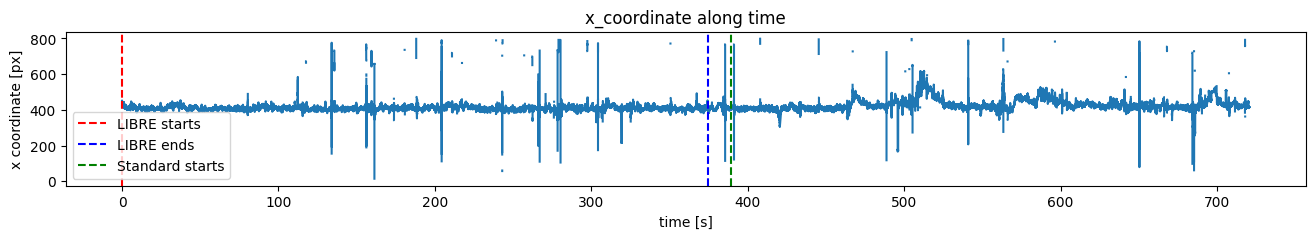

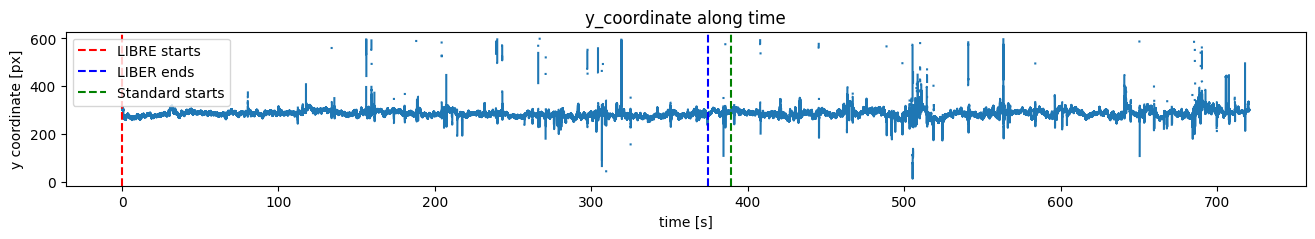

In [253]:
start_margin = int(0.0*metadata['SamplingFrequency'])
if mode == 'T1':
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T1_LIBRE_sample = T1_LIBRE*metadata['SamplingFrequency']
    T1_GAP_sample = T1_GAP*metadata['SamplingFrequency']
    T1_VIBE = len(coor_data) - T1_LIBRE_sample - T1_GAP_sample
else:
    print(f'mode: {mode}')
    print(f"set start margin as {start_margin}")
    T2_LIBRE_sample = T2_LIBRE*metadata['SamplingFrequency']
    T2_GAP_sample = T2_GAP*metadata['SamplingFrequency']
    T2_TSE = len(coor_data) - T2_LIBRE_sample - T2_GAP_sample
    


t_axis_xy = (
    coor_data.index 
) / metadata["SamplingFrequency"]

# x coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["x_coordinate"].values,
)

if mode == 'T1':
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBRE ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("x_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("x coordinate [px]")
plt.legend()

# y coordinate
fig = plt.figure(figsize=(16, 2))

plt.plot(
    t_axis_xy,
    coor_data["y_coordinate"].values,
)
if mode == "T1":
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T1_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T1_LIBRE_sample+start_margin+T1_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
else:
    plt.axvline(x=start_margin/metadata["SamplingFrequency"], color='r', linestyle='--', label='LIBRE starts')
    plt.axvline(x=(T2_LIBRE_sample+start_margin)/ metadata["SamplingFrequency"], color='b', linestyle='--', label='LIBER ends')
    plt.axvline(x=(T2_LIBRE_sample+start_margin+T2_GAP_sample)/metadata["SamplingFrequency"], color='g', 
                linestyle='--', label='Standard starts')
    
plt.title("y_coordinate along time")
plt.xlabel("time [s]")
plt.ylabel("y coordinate [px]")
plt.legend()

if mode == 'T1':
    coor_data_LIBRE = coor_data[start_margin:int(T1_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T1_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T1_LIBRE_sample+start_margin+T1_GAP_sample):] 
else:
    coor_data_LIBRE = coor_data[start_margin:int(T2_LIBRE_sample)] 
    coor_recording_LIBRE = coor_recording[start_margin:int(T2_LIBRE_sample)] 
    coor_data_STANDARD = coor_data[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
    coor_recording_STANDARD = coor_recording[int(T2_LIBRE_sample+start_margin+T2_GAP_sample):] 
coor_data_LIBRE_raw = copy.deepcopy(coor_data_LIBRE)
print(len(coor_data_LIBRE))
print(len(coor_data_STANDARD))

### Eliminating blinking

In [254]:
use_eliminate_blink = False

def eliminate_blink(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.blink < 1]
#     coor_recording = coor_recording[coor_recording.blink < 1]
# Note: instead of filtering them out, I assign nan to the invalid elements
    print(f'The data will be eliminated: {len(coor_data[coor_recording.blink > 0])}')
    coor_data.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.blink > 0,  ['x_coordinate', 'y_coordinate']] = np.nan
    print(f'After eliminating blinking: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_eliminate_blink:
    coor_data_LIBRE,  coor_recording_LIBRE = eliminate_blink(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
# coor_data_STANDARD,  coor_recording_STANDARD = eliminate_blink(coor_data_STANDARD, 
#                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

In [255]:
# # inspect the blinking
# coor_data_LIBRE[coor_recording_LIBRE.blink > 0]

### Preserving fixation

In [256]:
use_preserve_fixation = False

def preserve_fixation(coor_data, coor_recording, seq_name):
#     coor_data = coor_data[coor_recording.fixation > 0]
#     coor_recording = coor_recording[coor_recording.fixation > 0]
    print(f'The data will be eliminated: {len(coor_data[coor_recording.fixation < 1])}')
    coor_data.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan
    coor_recording.loc[coor_recording.fixation < 1, ['x_coordinate', 'y_coordinate']] = np.nan

    print(f'After preserving fixation: \nlen of coor_data_{seq_name} {len(coor_data)} \
      should be equal to len of coor_recording {len(coor_recording)}')
    return coor_data, coor_recording


if use_preserve_fixation:
    coor_data_LIBRE,  coor_recording_LIBRE = preserve_fixation(coor_data_LIBRE, coor_recording_LIBRE, 'LIBRE')
    # coor_data_STANDARD,  coor_recording_STANDARD = preserve_fixation(coor_data_STANDARD, 
    #                                                                coor_recording_STANDARD, 'STANDARD')
plot_heatmap = False
if plot_heatmap:
    import plot
    plot.plot_heatmap_coordinate(coor_data_LIBRE, density=False, screen_size=size, 
                                 title='LIBRE: The gaze from the beginning to the end')
    plot.plot_heatmap_coordinate(coor_data_STANDARD, density=False, screen_size=size, 
                                 title='STANDARD: The gaze from the beginning to the end')

### Plot the gazing dots

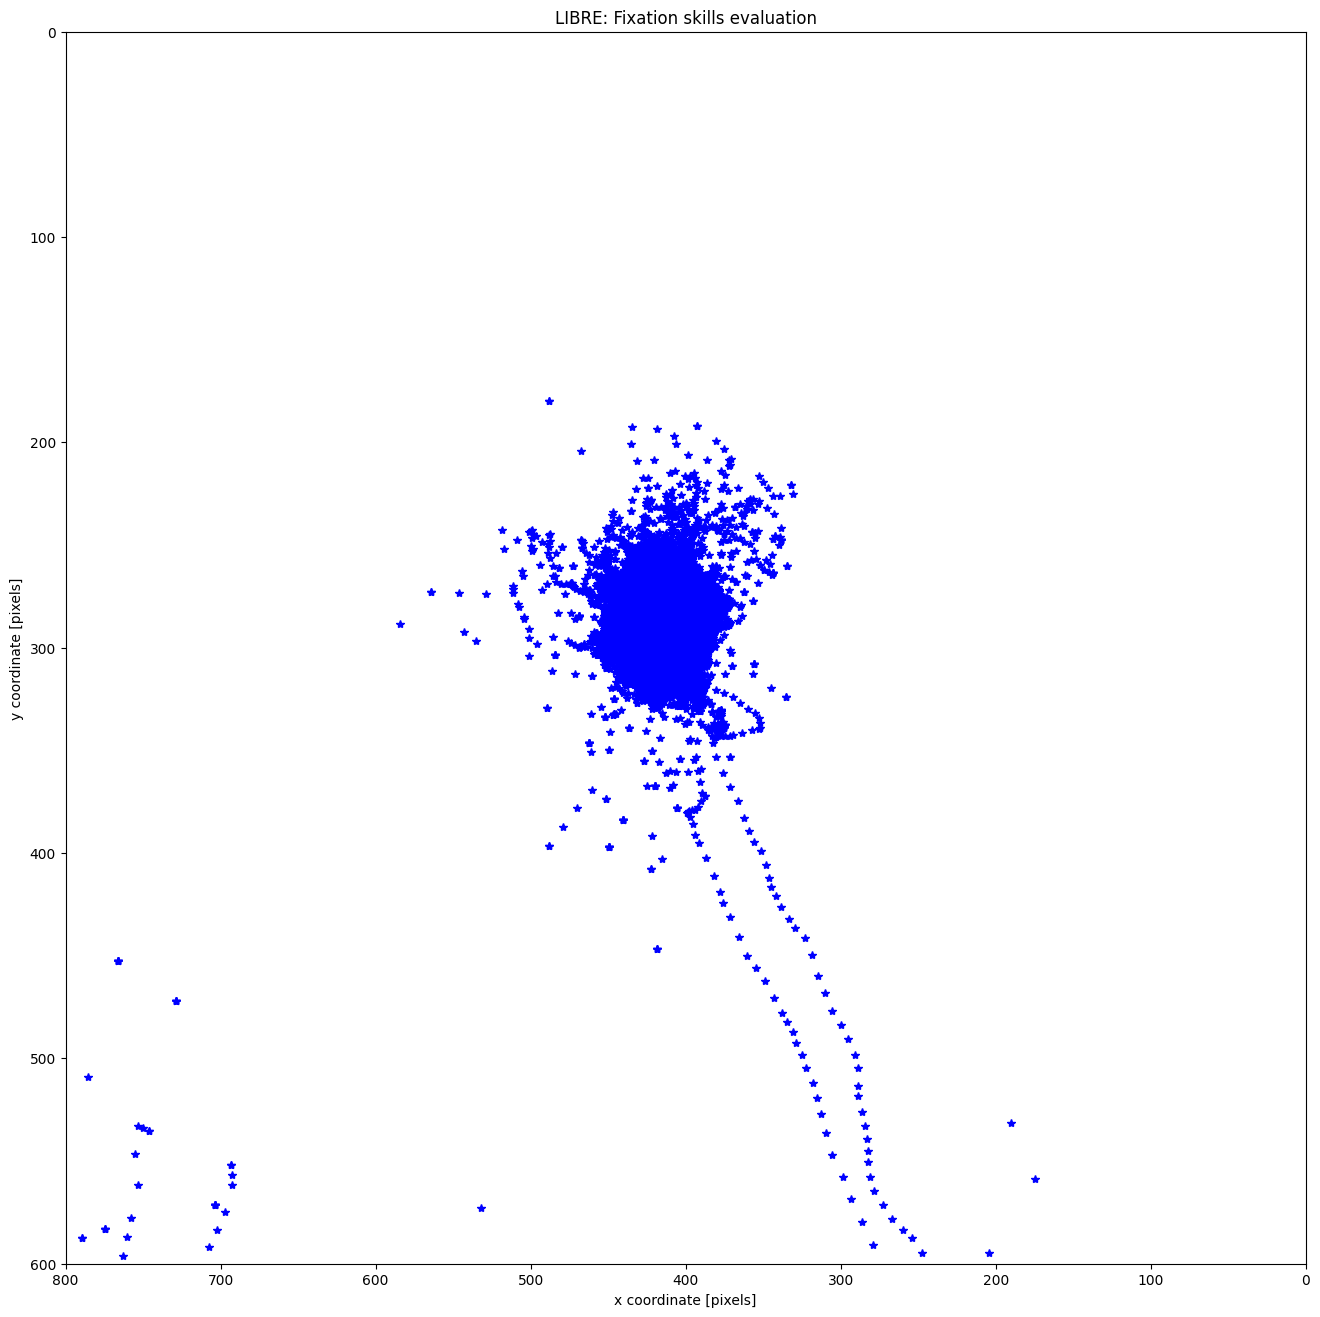

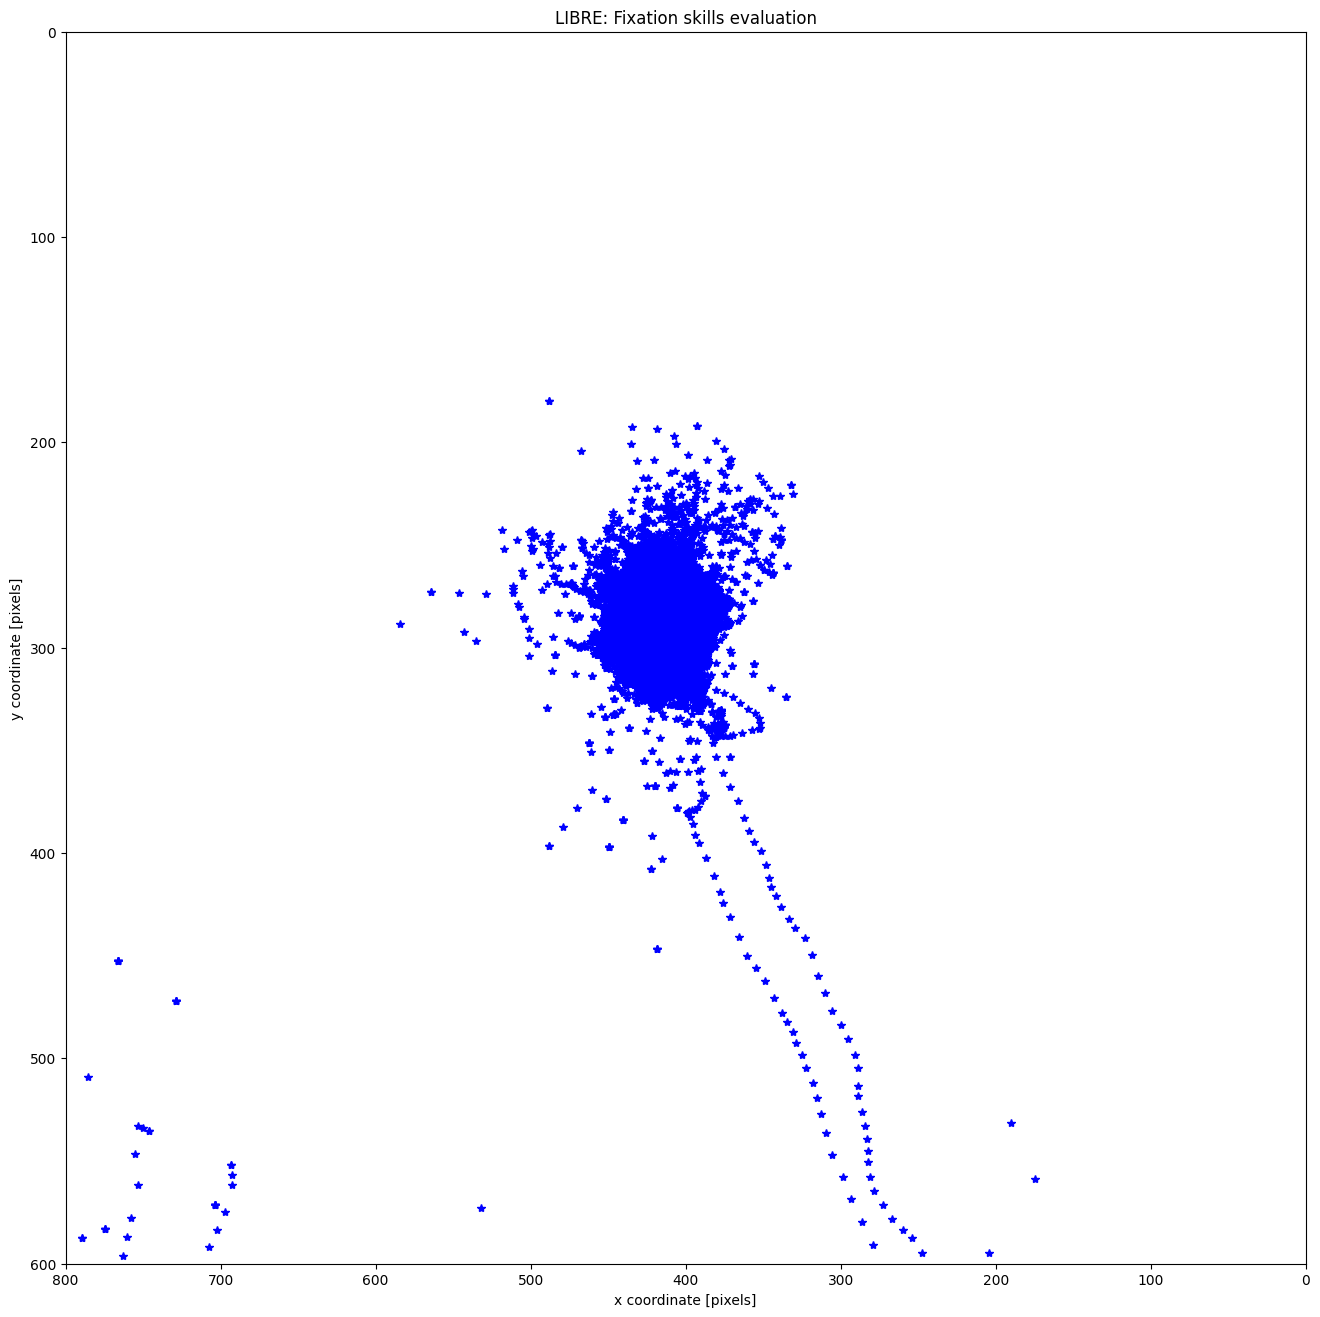

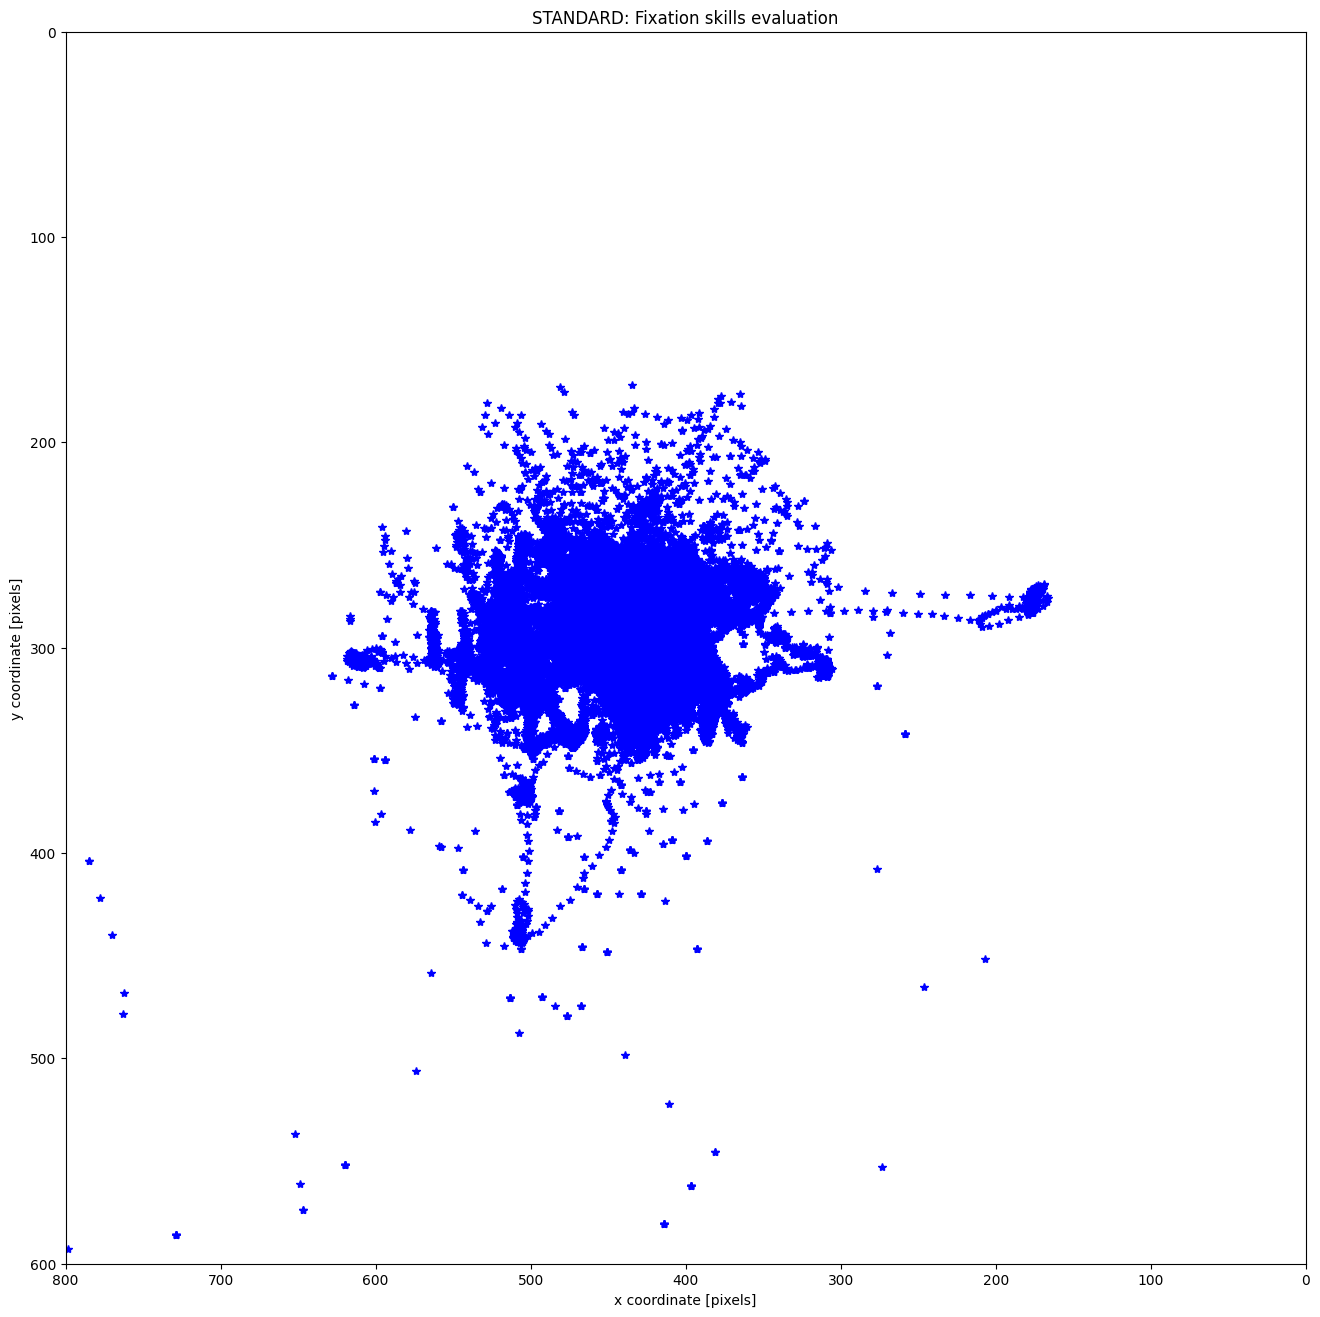

In [257]:
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE_raw['x_coordinate']
Y_coord = coor_data_LIBRE_raw['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Fixation skills evaluation')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_LIBRE['x_coordinate']
Y_coord = coor_data_LIBRE['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('LIBRE: Fixation skills evaluation')
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ============================================================
# Example data (replace with your actual data)
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
plt.xlabel('x coordinate [pixels]')
plt.ylabel('y coordinate [pixels]')
# Set plot title
plt.title('STANDARD: Fixation skills evaluation')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


By far, we initially cleaned data based on the inherent properties in the metadata from EyeLink. And we plotted the fixation evaluation,which show still distributed gazing dots instead of a clustered area. 

### Visual Angle

#### Method 2

In [258]:
def cal_disp(coor_data, stand_x_upper=0.15, stand_x_lower=-0.15, stand_y_upper=0.15, stand_y_lower=-0.15):
    Disp_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    print(f'X_coord {X_coord}')
    print(f'Y_coord {Y_coord}')
    print('After cleaning nan, eminating data affected by blinking,\
            and preserving the fixation ')
    print(f'The length of X coordinate data: {len(X_coord)}')
    print(f'The length of Y coordinate data: {len(Y_coord)}')

    # Distance head-coil projector 102 cm  - size of an emmetrope eye varies from 2.1 cm to 2.7 cm 
    # (eye with a perfect vision)
    # in mm - this is common to both horizontal and angular rotation. 24 is 2.4cm which is the size of eye
    distance_from_screen = 1020
    diameter = 24 
    Cat1 =  diameter + distance_from_screen
    print('check here is the eye size is defined manually?  can we extract the info from metadata?')

    # Depends on projector resolution, where 176px corresponds to 81.3 mm; 
    # so the formula becomes (Recorded_traj_px - center in px)*81.3/176
    # computation measures in mm， convert from px to mm
    # Transfer from pixel domain to mm, and shift the displacement to the center of screen
    # Compared to the only one mask, here the tangent value can be negative
    Cat2_hor = np.where(np.isnan(X_coord), np.nan, (X_coord - 400) * 81.3 / 176)
    Cat2_ver = np.where(np.isnan(Y_coord), np.nan, (Y_coord - 300) * 62 / 137)
    
    Hor_rot = np.where(np.isnan(Cat2_hor), np.nan, np.arctan(Cat2_hor / Cat1))
    Ver_rot = np.where(np.isnan(Cat2_ver), np.nan, np.arctan(Cat2_ver / Cat1))
#     print(Hor_rot)

    Disp_mm_eye_x =  np.sin(2*Hor_rot)*(diameter/2) # 12: radius of the eye
    Disp_mm_eye_y =  np.sin(2*Ver_rot)*(diameter/2)
    print(f'Disp_mm_eye_x: {Disp_mm_eye_x}')
    
    Disp_dict['Disp_mm_eye'] = (Disp_mm_eye_x, Disp_mm_eye_y)

    med_x = np.nanmedian(Disp_mm_eye_x)
    print(f'med_x {med_x}')
    med_y = np.nanmedian(Disp_mm_eye_y)
    print(f'med_y {med_y}')
    Disp_dict['Disp_med'] = (med_x, med_y)
    # 0.5*std(Disp_mm_eye_y);

    # Subtract median
    Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
    Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y
    Disp_dict['Disp_mm_eye_minus_med'] = (Disp_mm_eye_x_minus_mx, Disp_mm_eye_y_minus_my)
    
    Ms_to_be_discarded_x_mask = (
            np.logical_or(
                Disp_mm_eye_x_minus_mx > stand_x_upper,
                Disp_mm_eye_x_minus_mx < stand_x_lower
            ) | np.isnan(Disp_mm_eye_x_minus_mx)
        )
    Ms_to_be_discarded_y_mask = (
            np.logical_or(
                Disp_mm_eye_y_minus_my > stand_y_upper,
                Disp_mm_eye_y_minus_my < stand_y_lower
            ) | np.isnan(Disp_mm_eye_y_minus_my)
        )
    Disp_dict['Ms_to_be_discarded_mask'] = (Ms_to_be_discarded_x_mask, Ms_to_be_discarded_y_mask)
    Disp_dict['stand_xy'] = (stand_x_upper, stand_x_lower, stand_y_upper, stand_y_lower)
    return Disp_dict


In [259]:
def plot_x_y_coord(Disp_dict, metadata, duration=None, start_sample=0, seq_name=None):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=24, weight='bold')
    
    Disp_mm_eye_x = Disp_dict['Disp_mm_eye'][0]
    Disp_mm_eye_y = Disp_dict['Disp_mm_eye'][1]
    Disp_mm_eye_x_minus_mx = Disp_dict['Disp_mm_eye_minus_med'][0]
    Disp_mm_eye_y_minus_my = Disp_dict['Disp_mm_eye_minus_med'][1]
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    if duration == None:
        end_sample = len(Disp_mm_eye_x)
    else:    
        end_sample = duration*metadata["SamplingFrequency"]

    t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

    # Horizontal direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x[start_sample:end_sample],
        marker='o', color='blue',
        label="Horizontal displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_x_minus_mx[start_sample:end_sample],
        marker='*', color='green',
        label='Horizontal displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_x_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_x_minus_mx[start_sample:end_sample] * Ms_to_be_discarded_x_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )
    ax.axhline(y=Disp_dict['stand_xy'][0], color='r', linestyle='--', label='+std')
    ax.axhline(y=Disp_dict['stand_xy'][1], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name, fontproperties=title_font)
    plt.tight_layout()

    # Vertical direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y[start_sample:end_sample],
        marker='o', color='blue',
        label="Vertical displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_y_minus_my[start_sample:end_sample],
        marker='*', color='green',
        label='Vertical displacement in mm - med x'
    )

    if len(Ms_to_be_discarded_y_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_y_minus_my[start_sample:end_sample] * Ms_to_be_discarded_y_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )

    ax.axhline(y=Disp_dict['stand_xy'][2], color='r', linestyle='--', label='+std')
    ax.axhline(y=Disp_dict['stand_xy'][3], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name, fontproperties=title_font)
    plt.tight_layout()



In [260]:
from matplotlib.font_manager import FontProperties
title_font = FontProperties(family='Times New Roman', size=24, weight='bold')

def filter_XY_coord(coor_data, Disp_dict, seq_name=None):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=35, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
#     x y coordinate accordingly
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    Ms_to_be_discarded_x_mask = Disp_dict['Ms_to_be_discarded_mask'][0]
    Ms_to_be_discarded_y_mask = Disp_dict['Ms_to_be_discarded_mask'][1]
    
    Combined_mask = ~(Ms_to_be_discarded_x_mask|Ms_to_be_discarded_y_mask)
   
    filtered_X_coord = X_coord * Combined_mask
    filtered_Y_coord = Y_coord * Combined_mask

    zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
    filtered_X_coord[zero_mask] = np.nan
    filtered_Y_coord[zero_mask] = np.nan
    
    Discard_mask = np.where(np.isnan(filtered_X_coord) | np.isnan(filtered_Y_coord), 1, 0)

    # Example data (replace with your actual data)
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(filtered_X_coord, filtered_Y_coord, '.', color='#00468b',markersize=15)
    plt.xlim(0, 800)
    plt.ylim((0, 600))
    # Set plot title
    if seq_name is not None:
        plt.title(f'Fixation skills evaluation after screening: {seq_name}', fontproperties=title_font)
    else:     
        plt.title('Fixation skills evaluation after screening', fontproperties=title_font)

    # Reverse the direction of the Y-axis
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    coor_data["x_coordinate"] = filtered_X_coord
    coor_data["y_coordinate"] = filtered_Y_coord
    
    return coor_data, Combined_mask, Discard_mask
    




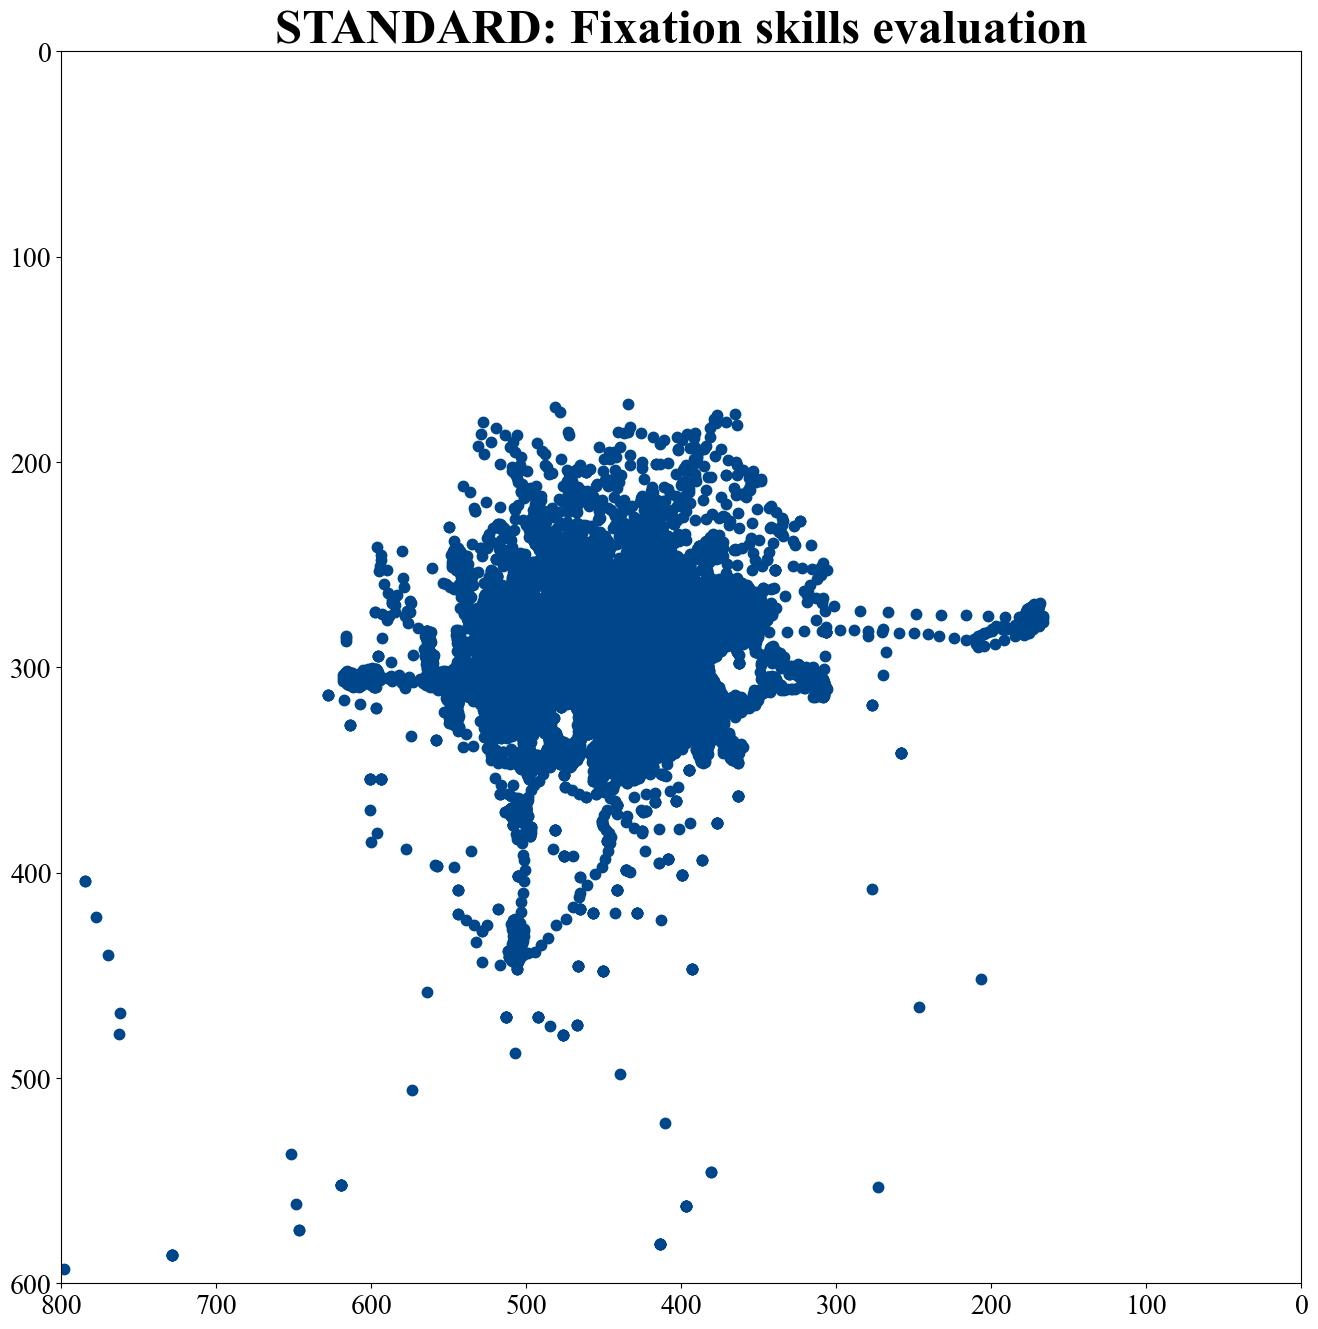

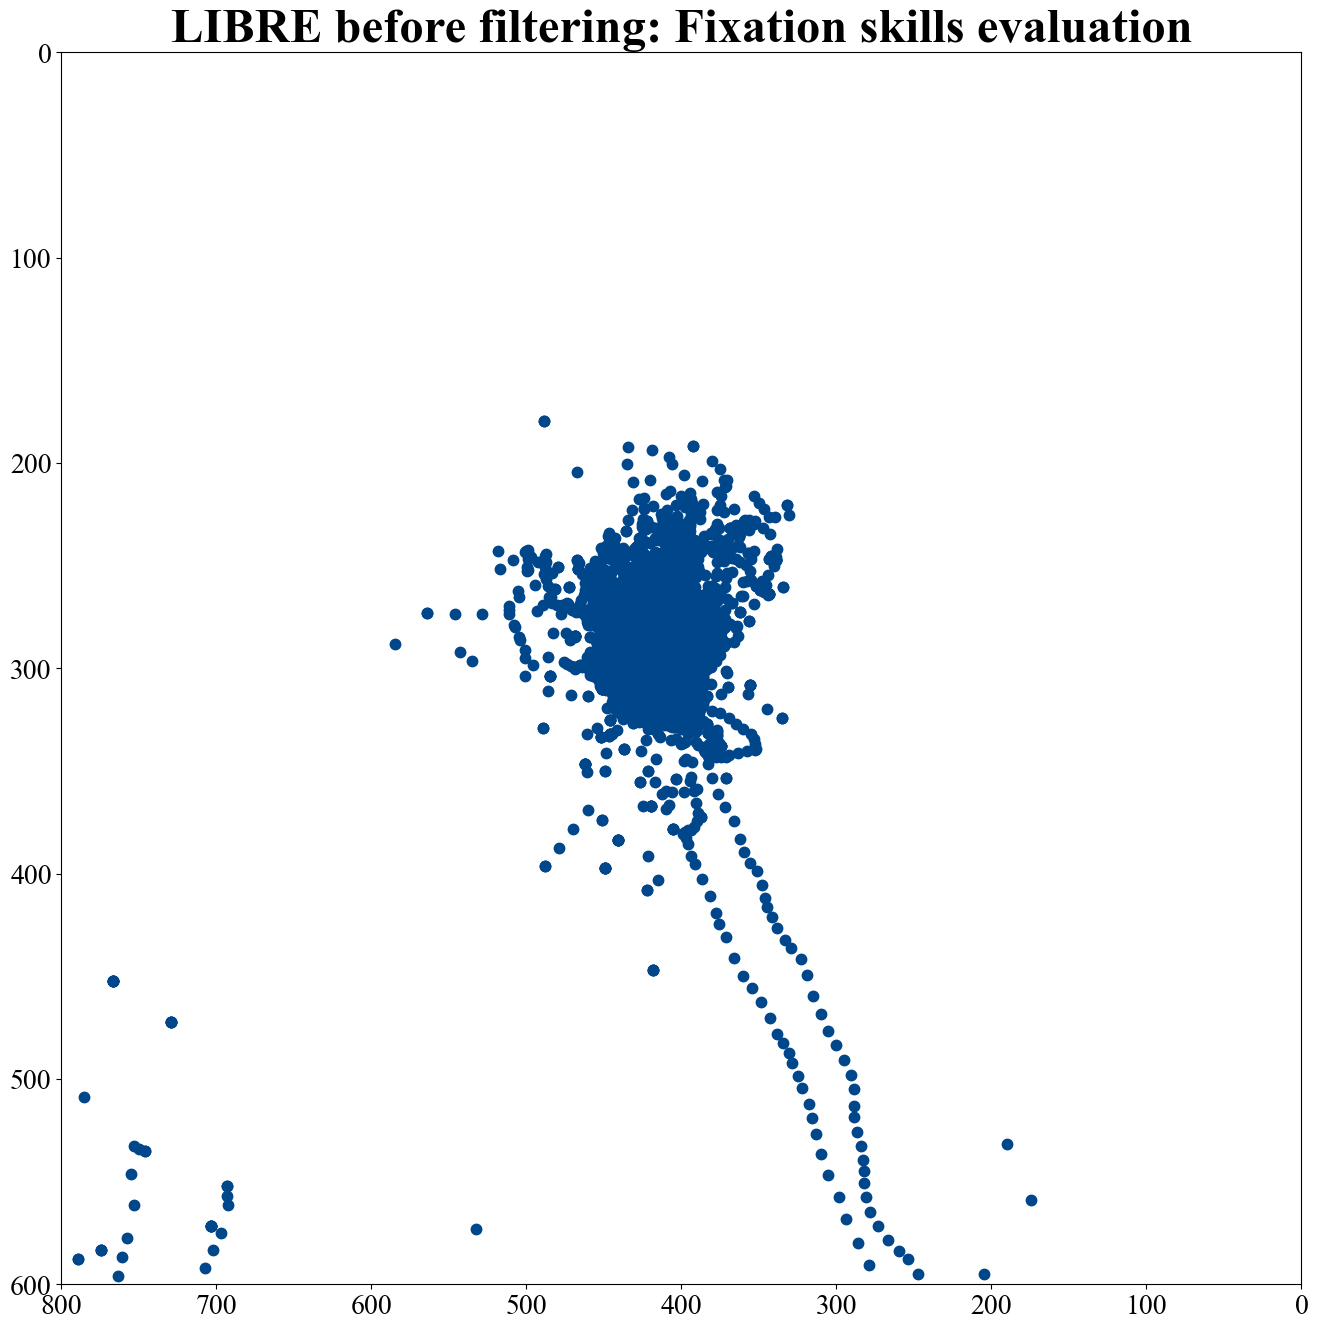

In [261]:
def plot_gaze_points(X_coord, Y_coord, fig_title):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=35, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
    
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(X_coord, Y_coord, '.', color='#00468b', markersize=15)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
    plt.title(fig_title, fontproperties=title_font)
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
#     ---------------------------------------------------------------------
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig_title = 'STANDARD: Fixation skills evaluation'
plot_gaze_points(X_coord, Y_coord, fig_title)

coor_data_LIBRE_ = copy.deepcopy(coor_data_LIBRE_raw)
X_coord = coor_data_LIBRE_['x_coordinate']
Y_coord = coor_data_LIBRE_['y_coordinate']
fig_title = 'LIBRE before filtering: Fixation skills evaluation'
plot_gaze_points(X_coord, Y_coord, fig_title)

X_coord [414.1000061  416.29998779 419.70001221 ... 398.79998779 399.29998779
 399.79998779]
Y_coord [307.8999939  308.3999939  309.20001221 ... 273.79998779 273.
 272.70001221]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 374380
The length of Y coordinate data: 374380
check here is the eye size is defined manually?  can we extract the info from metadata?
Disp_mm_eye_x: [ 0.14972386  0.17308256  0.20918094 ... -0.01274307 -0.00743351
 -0.00212395]
med_x 0.0987560351821146
med_y -0.1685294450986811


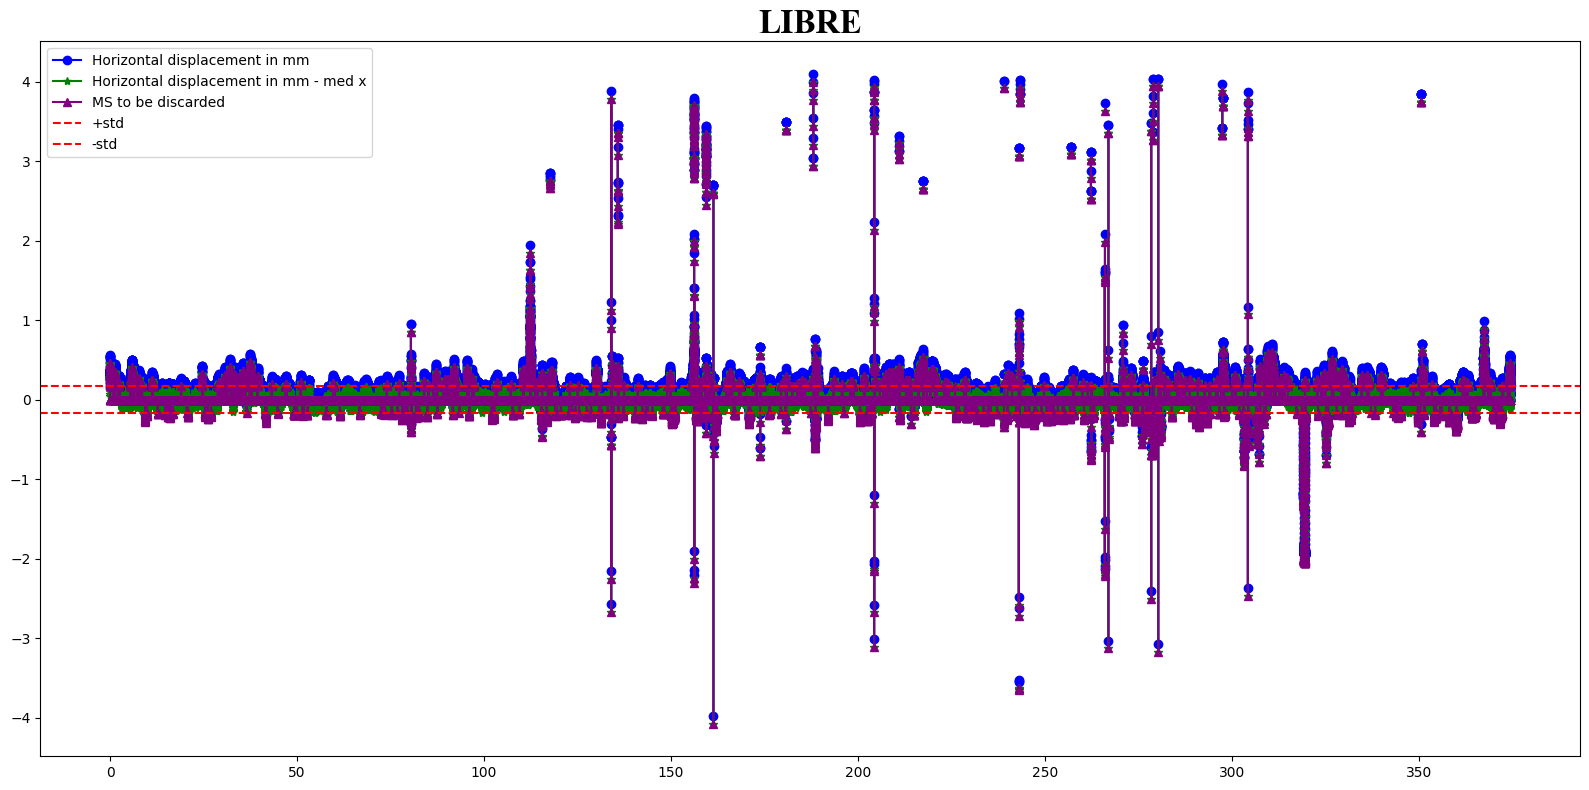

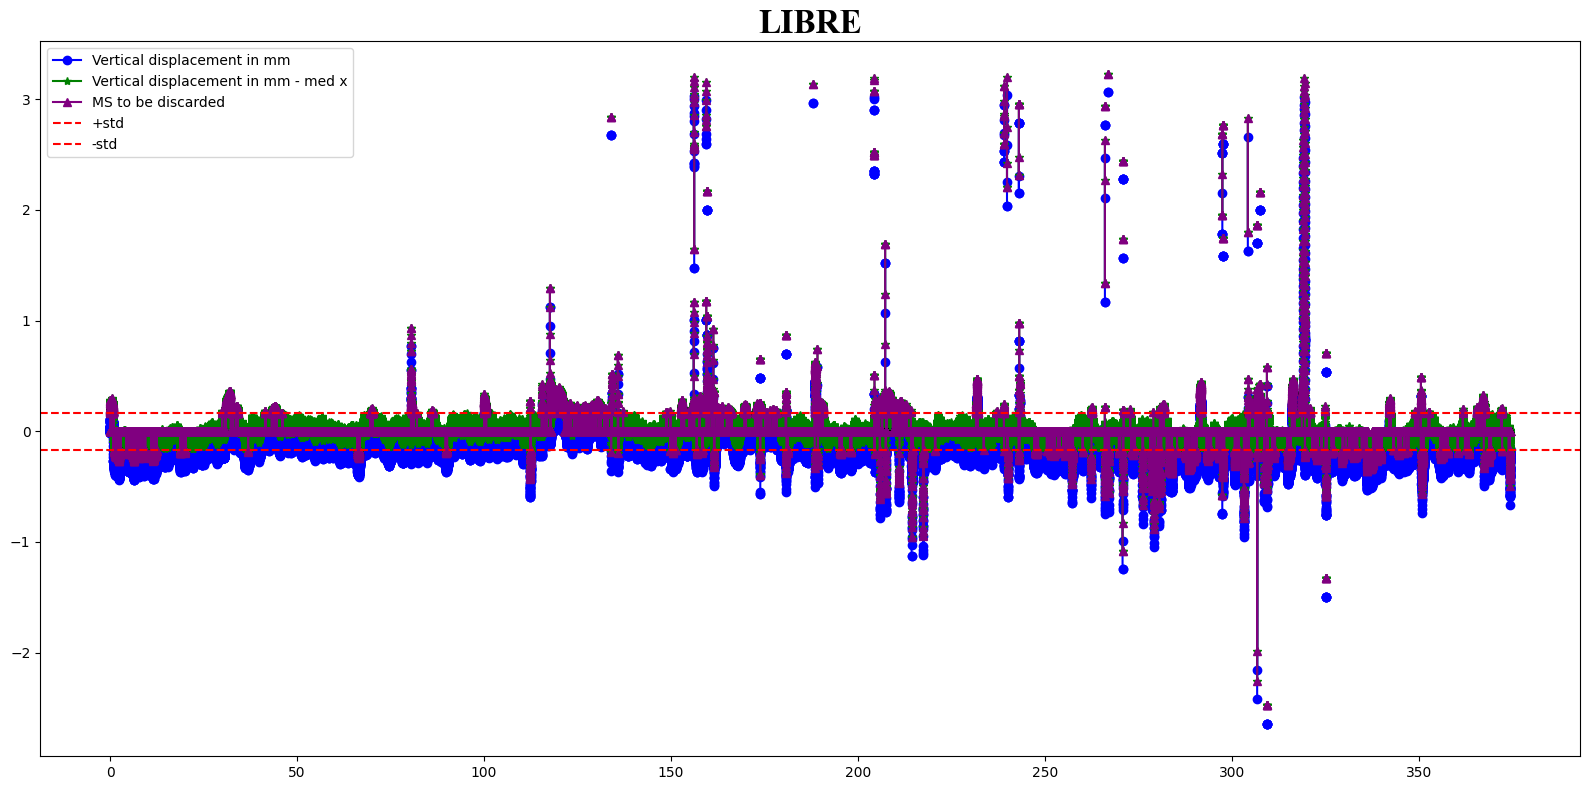

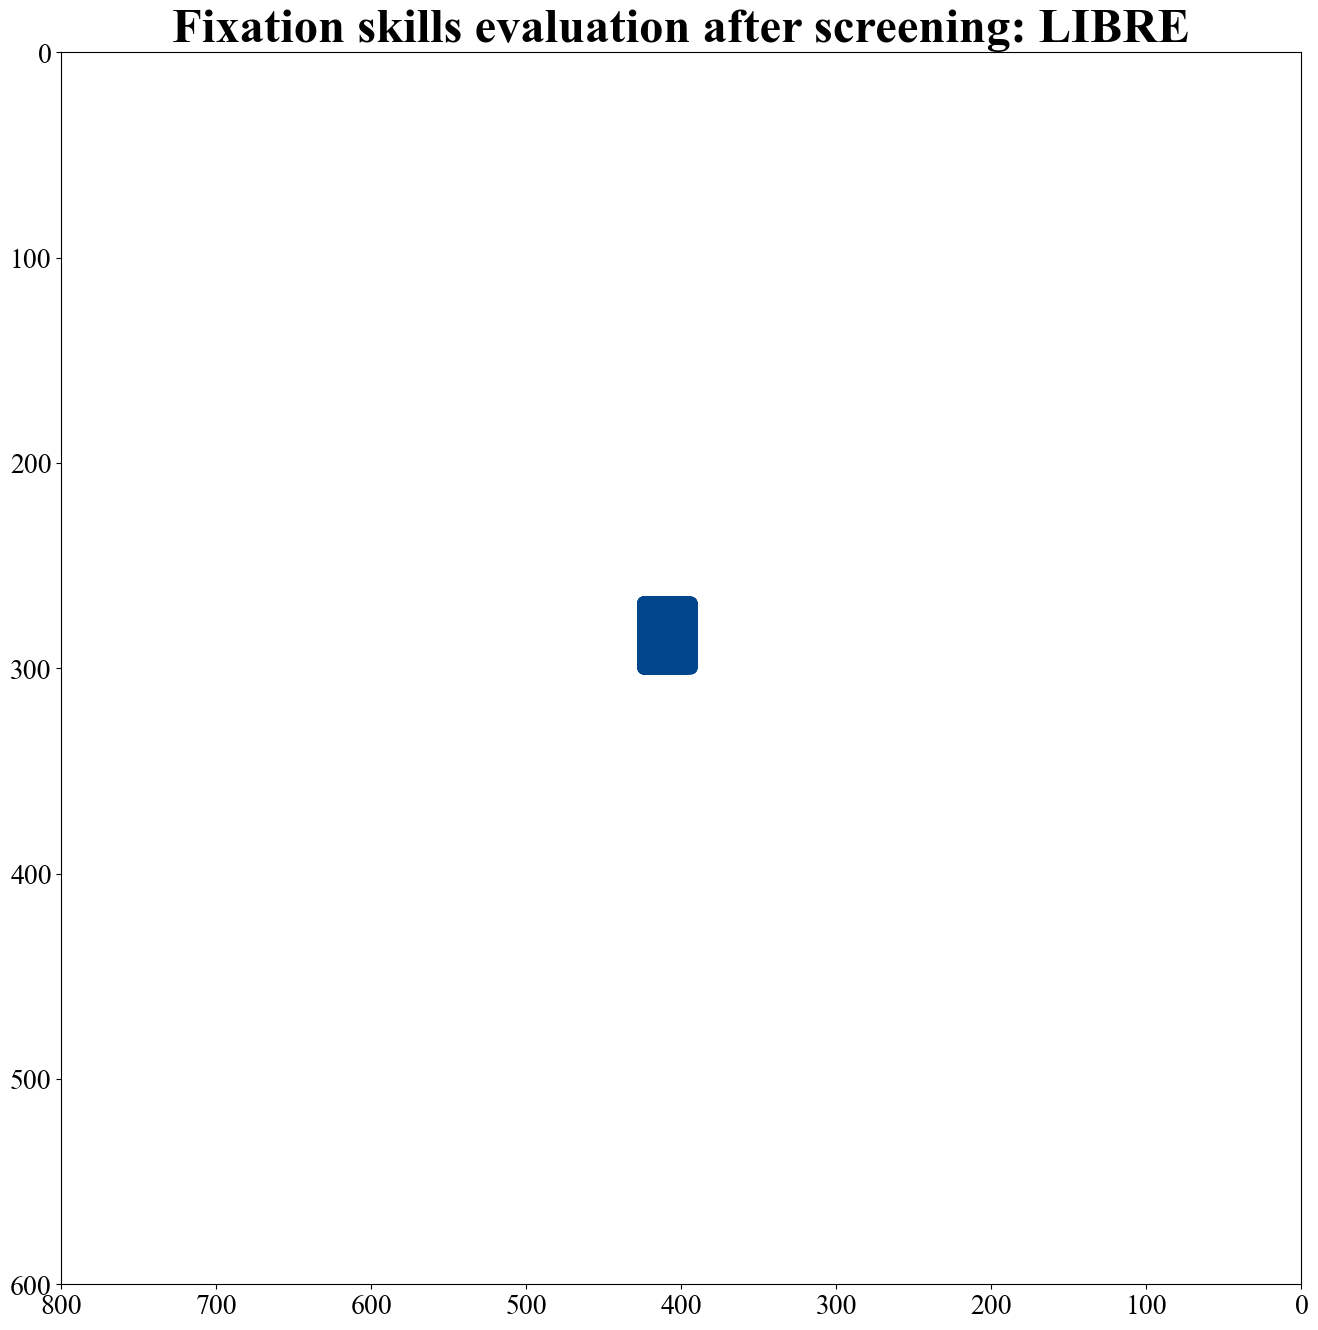

In [262]:
coor_data_LIBRE_1 = copy.deepcopy(coor_data_LIBRE)
Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_1, stand_x_upper=0.5*(1/3), stand_x_lower=-0.5*(1/3), 
                           stand_y_upper=0.5*(1/3), stand_y_lower=-0.5*(1/3))
plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
filtered_coor_data_LIBRE, Preserve_mask, Discard_mask = filter_XY_coord(coor_data_LIBRE_1, Disp_dict_LIBRE, 'LIBRE')


# coor_data_LIBRE_2 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_2, stand_x=0.5*(1/3), stand_y=0.5*(1/3))
# plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_XY_coord(coor_data_LIBRE_2, Disp_dict_LIBRE, 'LIBRE')

# coor_data_LIBRE_3 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_3, stand_x=0.5*(1/4), stand_y=0.5*(1/4))
# plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_XY_coord(coor_data_LIBRE_3, Disp_dict_LIBRE, 'LIBRE')

# plot_x_y_coord(Disp_dict_STANDARD, metadata, duration=None, start_sample=0, seq_name='STANDARD')

In [263]:
count_true = np.sum(Preserve_mask)
print(count_true)
# Save the Preserve_mask
import os
import scipy.io as sio

mask_name = f'{FILE_NAME}_mask_meth2_0_33.mat'
if subject_idx == 1:
    SAVE_PATH = Path("C:\\yiwei\\240912_recon\\Sub001\\T1_LIBRE_Binning\\BinningEYE_meas_MID00453_FID57919_BEAT_LIBREon_eye")
elif subject_idx == 2:
    SAVE_PATH = Path("C:\\yiwei\\240912_recon\\Sub002\\T1_LIBRE_Binning\\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye")


# Create the folder if it doesn't exist
os.makedirs(SAVE_PATH, exist_ok=True)
mask_file = SAVE_PATH / mask_name

# Save array to a .mat file
sio.savemat(mask_file, {'array': Preserve_mask})
print(f'The mask file has been saved here: {mask_file}')

293545
The mask file has been saved here: C:\yiwei\240912_recon\Sub002\T1_LIBRE_Binning\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye\BF_T1_mask_meth2_0_33.mat


In [265]:
save_Discard_mask = True
print(len(Preserve_mask))
if save_Discard_mask:
    Discard_mask = ~Preserve_mask
    count_true = np.sum(Discard_mask)
    print(count_true)
    # Save the Preserve_mask
    import os
    import scipy.io as sio

    mask_name = f'{FILE_NAME}_discard_mask_meth2_0_33.mat'
    if subject_idx == 1:
        SAVE_PATH = Path("C:\\yiwei\\240912_recon\\Sub001\\T1_LIBRE_Binning\\BinningEYE_meas_MID00453_FID57919_BEAT_LIBREon_eye")
    elif subject_idx == 2:
        SAVE_PATH = Path("C:\\yiwei\\240912_recon\\Sub002\\T1_LIBRE_Binning\\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye")


    # Create the folder if it doesn't exist
    os.makedirs(SAVE_PATH, exist_ok=True)
    mask_file = SAVE_PATH / mask_name

    # Save array to a .mat file
    sio.savemat(mask_file, {'array': Discard_mask})
    print(f'The mask file has been saved here: {mask_file}')

374380
80835
The mask file has been saved here: C:\yiwei\240912_recon\Sub002\T1_LIBRE_Binning\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye\BF_T1_discard_mask_meth2_0_33.mat


if same 0         False
1         False
2         False
3         False
4         False
          ...  
374375     True
374376     True
374377     True
374378     True
374379     True
Name: x_coordinate, Length: 374380, dtype: bool


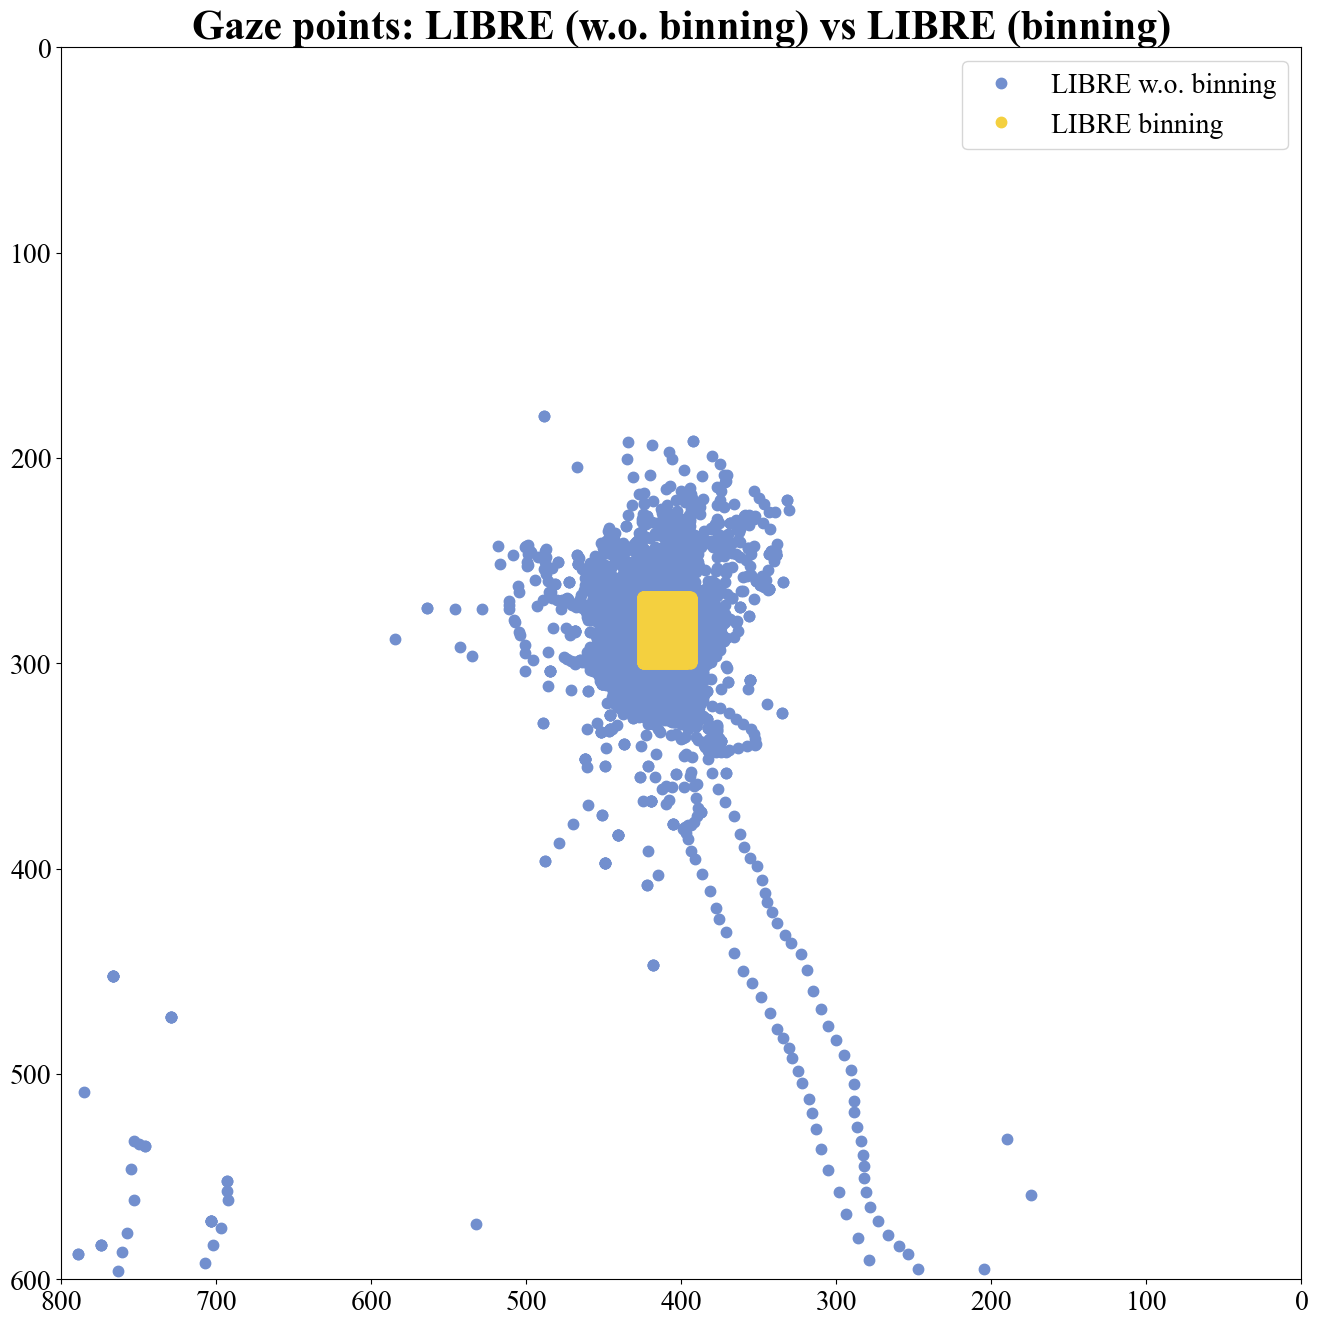

In [266]:
def visualization_func(fig_title, filtered_coor_data_LIBRE):
    from matplotlib.font_manager import FontProperties
    title_font = FontProperties(family='Times New Roman', size=30, weight='bold')
    axis_font = FontProperties(family='Times New Roman', size=20)
    
    fig, ax= plt.subplots(figsize=(16, 16))
    plt.title(fig_title, fontproperties=title_font)
#     -----------------------------------------------------------------------
#     # Plot the data, flipping X coordinates and using dots as markers
#     X_coord = coor_data_STANDARD['x_coordinate']
#     Y_coord = coor_data_STANDARD['y_coordinate']
#     plt.plot(X_coord, Y_coord, '.', color='#ADD8E6', markersize=15, label='Standard')
#     -----------------------------------------------------------------------
    coor_data_LIBRE_vis = copy.deepcopy(coor_data_LIBRE)
    X_coord_1 = coor_data_LIBRE_raw['x_coordinate']
    Y_coord_1 = coor_data_LIBRE_raw['y_coordinate']

    plt.plot(X_coord_1, Y_coord_1, '.', color='#728FCE', markersize=15, label='LIBRE w.o. binning')
    
#     -----------------------------------------------------------------------
    X_coord = filtered_coor_data_LIBRE['x_coordinate']
    Y_coord = filtered_coor_data_LIBRE['y_coordinate']
    print(F"if same {X_coord_1 == X_coord}")
    plt.plot(X_coord, Y_coord, '.', color='#f4d03f', markersize=15, label='LIBRE binning')
#     ----------------------------------------------------------------------------------------------
    plt.legend(prop={'family': 'Times New Roman', 'size': 20})
    
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.xlim((0, 800))
    plt.ylim((0, 600))
    # Set plot title
#     plt.title(fig_title, fontproperties=title_font)
    for label in plt.gca().get_xticklabels():
        label.set_fontproperties(axis_font)

    for label in plt.gca().get_yticklabels():
        label.set_fontproperties(axis_font)
    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()

    
# Visualization of filtered coor data LIBRE
visualization_func(fig_title='Gaze points: LIBRE (w.o. binning) vs LIBRE (binning)', 
                   filtered_coor_data_LIBRE=filtered_coor_data_LIBRE)



80835
293545
if same 0          True
1          True
2          True
3          True
4          True
          ...  
374375    False
374376    False
374377    False
374378    False
374379    False
Name: x_coordinate, Length: 374380, dtype: bool


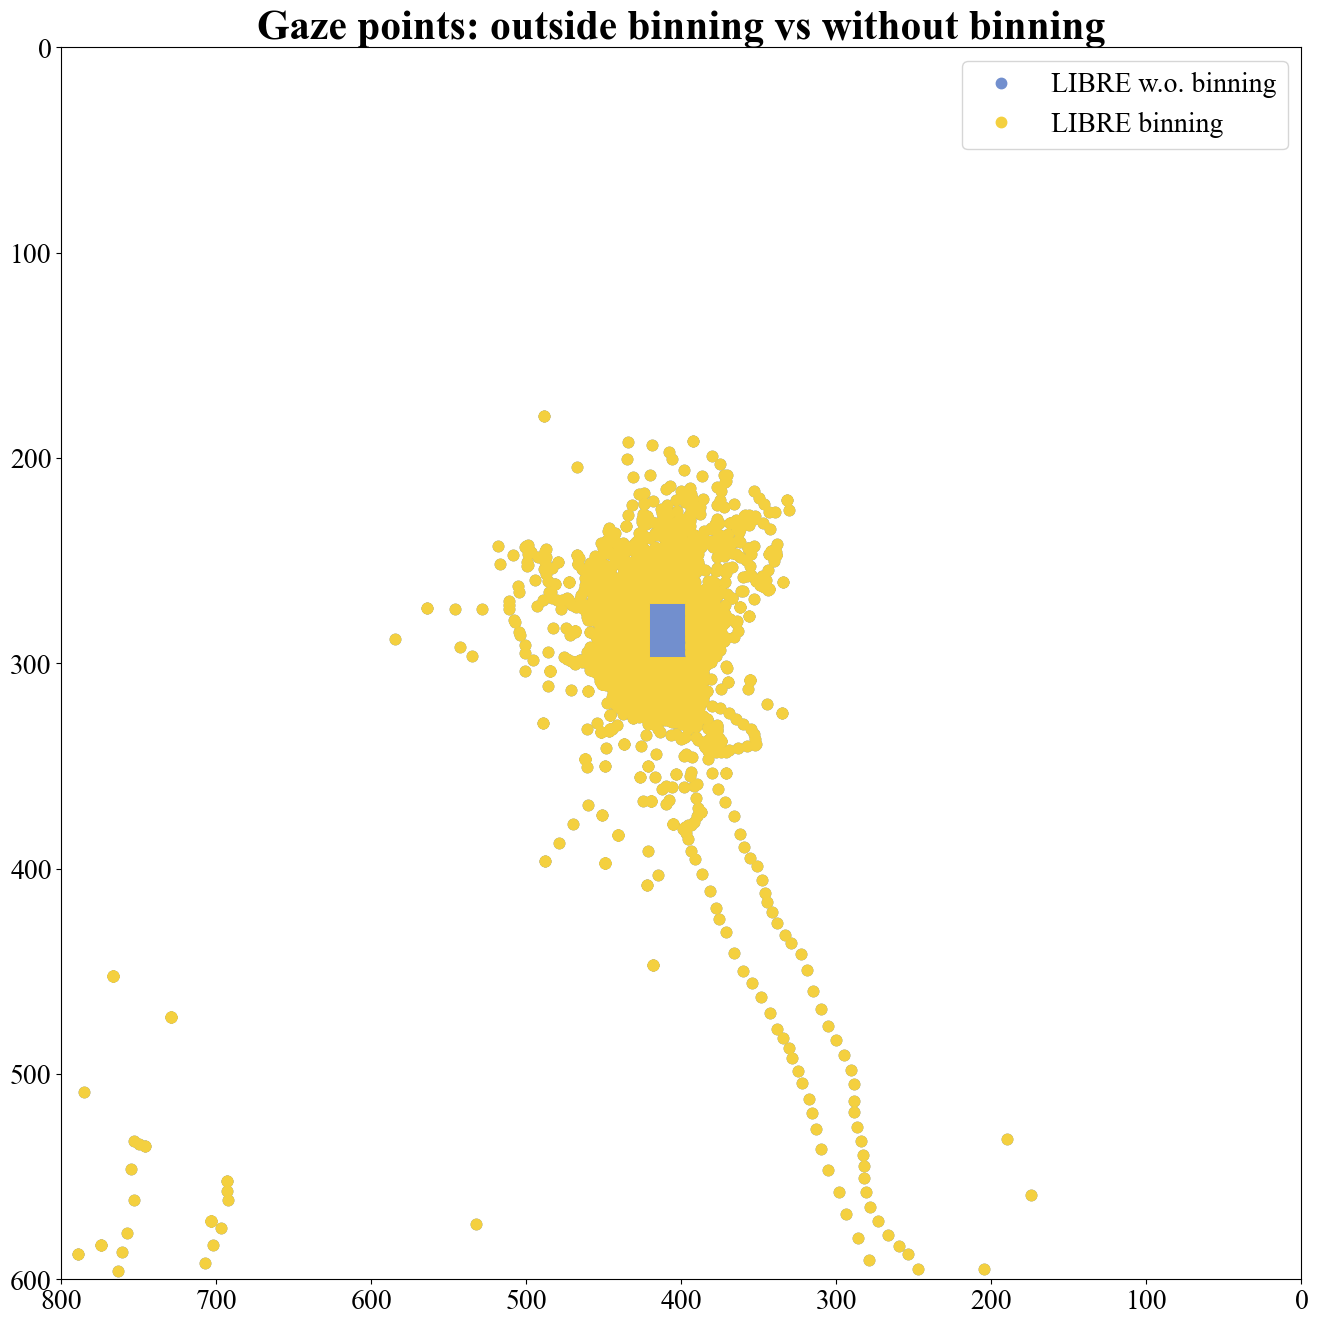

In [267]:
visualize_discarded_data = True
print(sum(Discard_mask))
if visualize_discarded_data:
    # Visualization of discarded data
    coor_data_LIBRE_discard = copy.deepcopy(coor_data_LIBRE_raw)
    X_coord_discard = coor_data_LIBRE_discard["x_coordinate"].values
    Y_coord_discard = coor_data_LIBRE_discard["y_coordinate"].values

    X_coord_discard = X_coord_discard * Discard_mask
    Y_coord_discard = Y_coord_discard * Discard_mask

    zero_mask = (X_coord_discard == 0) & (Y_coord_discard == 0)
    print(sum(zero_mask))
    X_coord_discard[zero_mask] = np.nan
    Y_coord_discard[zero_mask] = np.nan
    coor_data_LIBRE_discard["x_coordinate"] = X_coord_discard
    coor_data_LIBRE_discard["y_coordinate"] = Y_coord_discard
    
    visualization_func(fig_title='Gaze points: outside binning vs without binning', 
                       filtered_coor_data_LIBRE=coor_data_LIBRE_discard)

#### Multiple Masks

if num=4, divide the valid range into 4 parts

X_coord [414.1000061  416.29998779 419.70001221 ... 398.79998779 399.29998779
 399.79998779]
Y_coord [307.8999939  308.3999939  309.20001221 ... 273.79998779 273.
 272.70001221]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 374380
The length of Y coordinate data: 374380
check here is the eye size is defined manually?  can we extract the info from metadata?
Disp_mm_eye_x: [ 0.14972386  0.17308256  0.20918094 ... -0.01274307 -0.00743351
 -0.00212395]
med_x 0.0987560351821146
med_y -0.1685294450986811
if same 0         False
1         False
2         False
3         False
4         False
          ...  
374375    False
374376    False
374377    False
374378    False
374379    False
Name: x_coordinate, Length: 374380, dtype: bool
67540
The mask file has been saved here: C:\yiwei\240912_recon\Sub002\T1_LIBRE_Binning\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye\BF_T1_mask_meth2_0_33_4_0.mat
X_coord [414

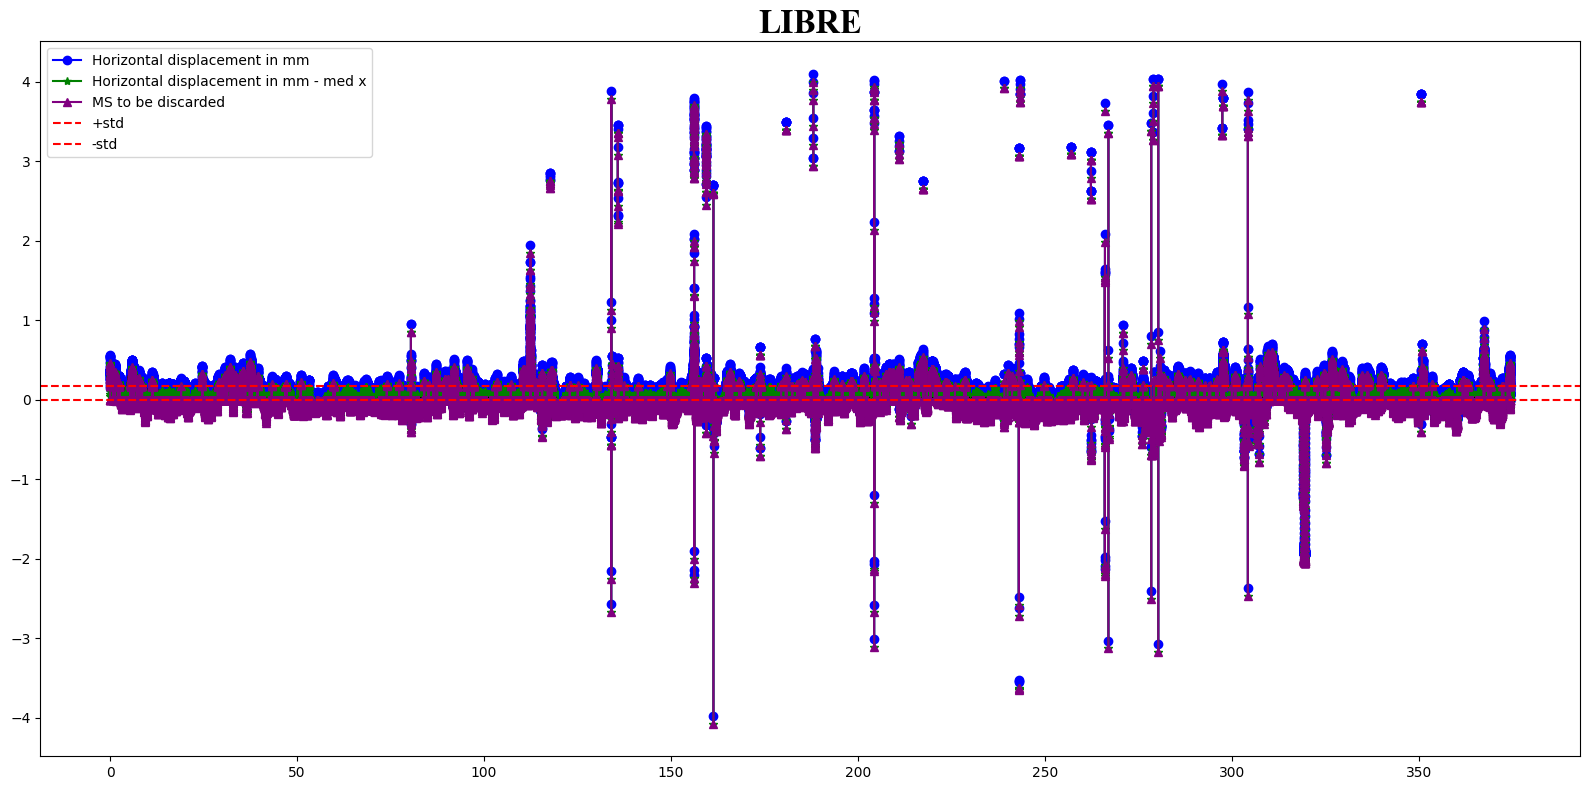

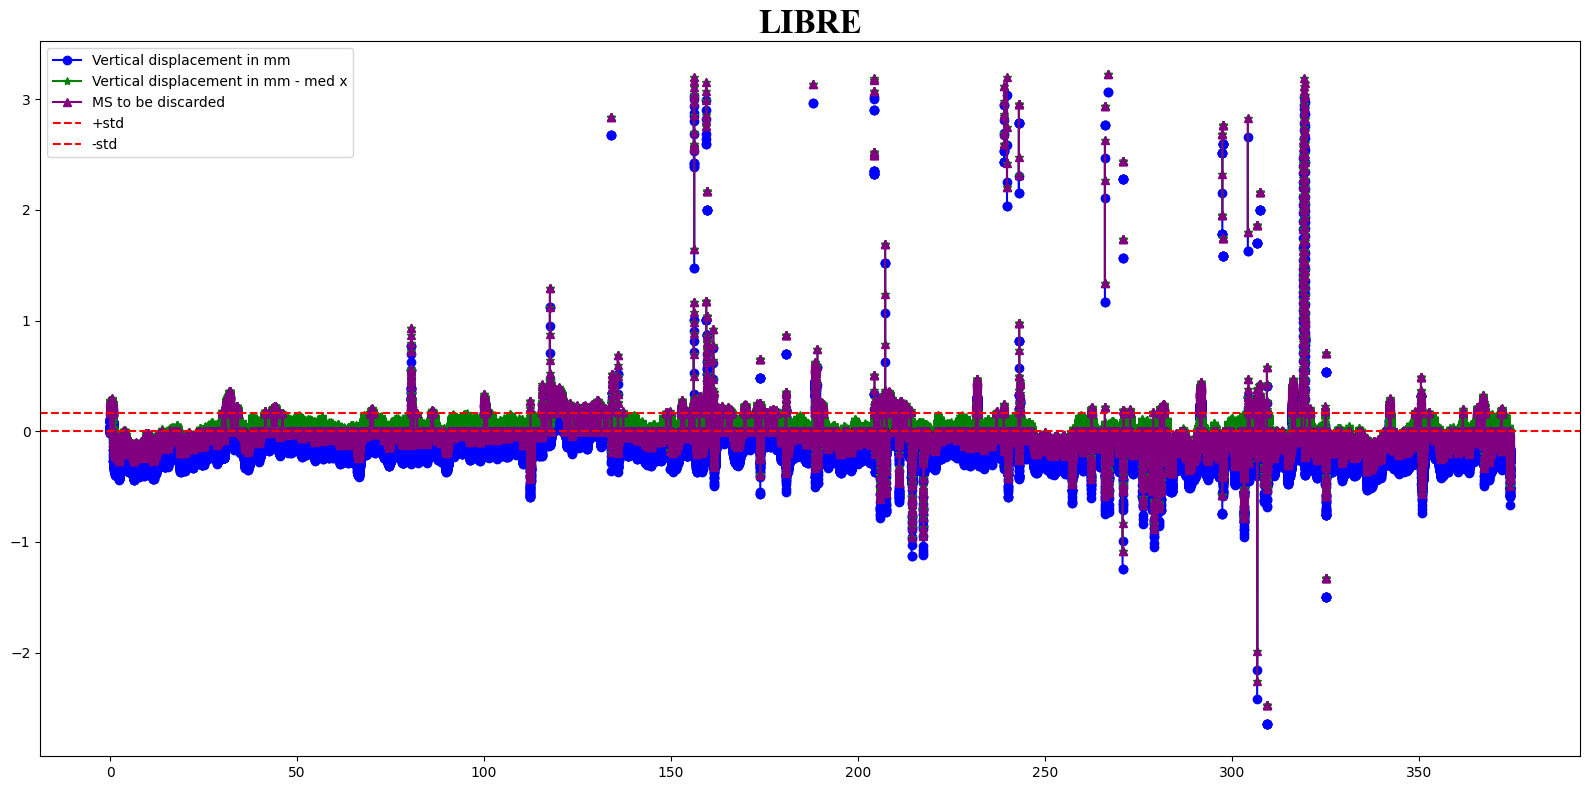

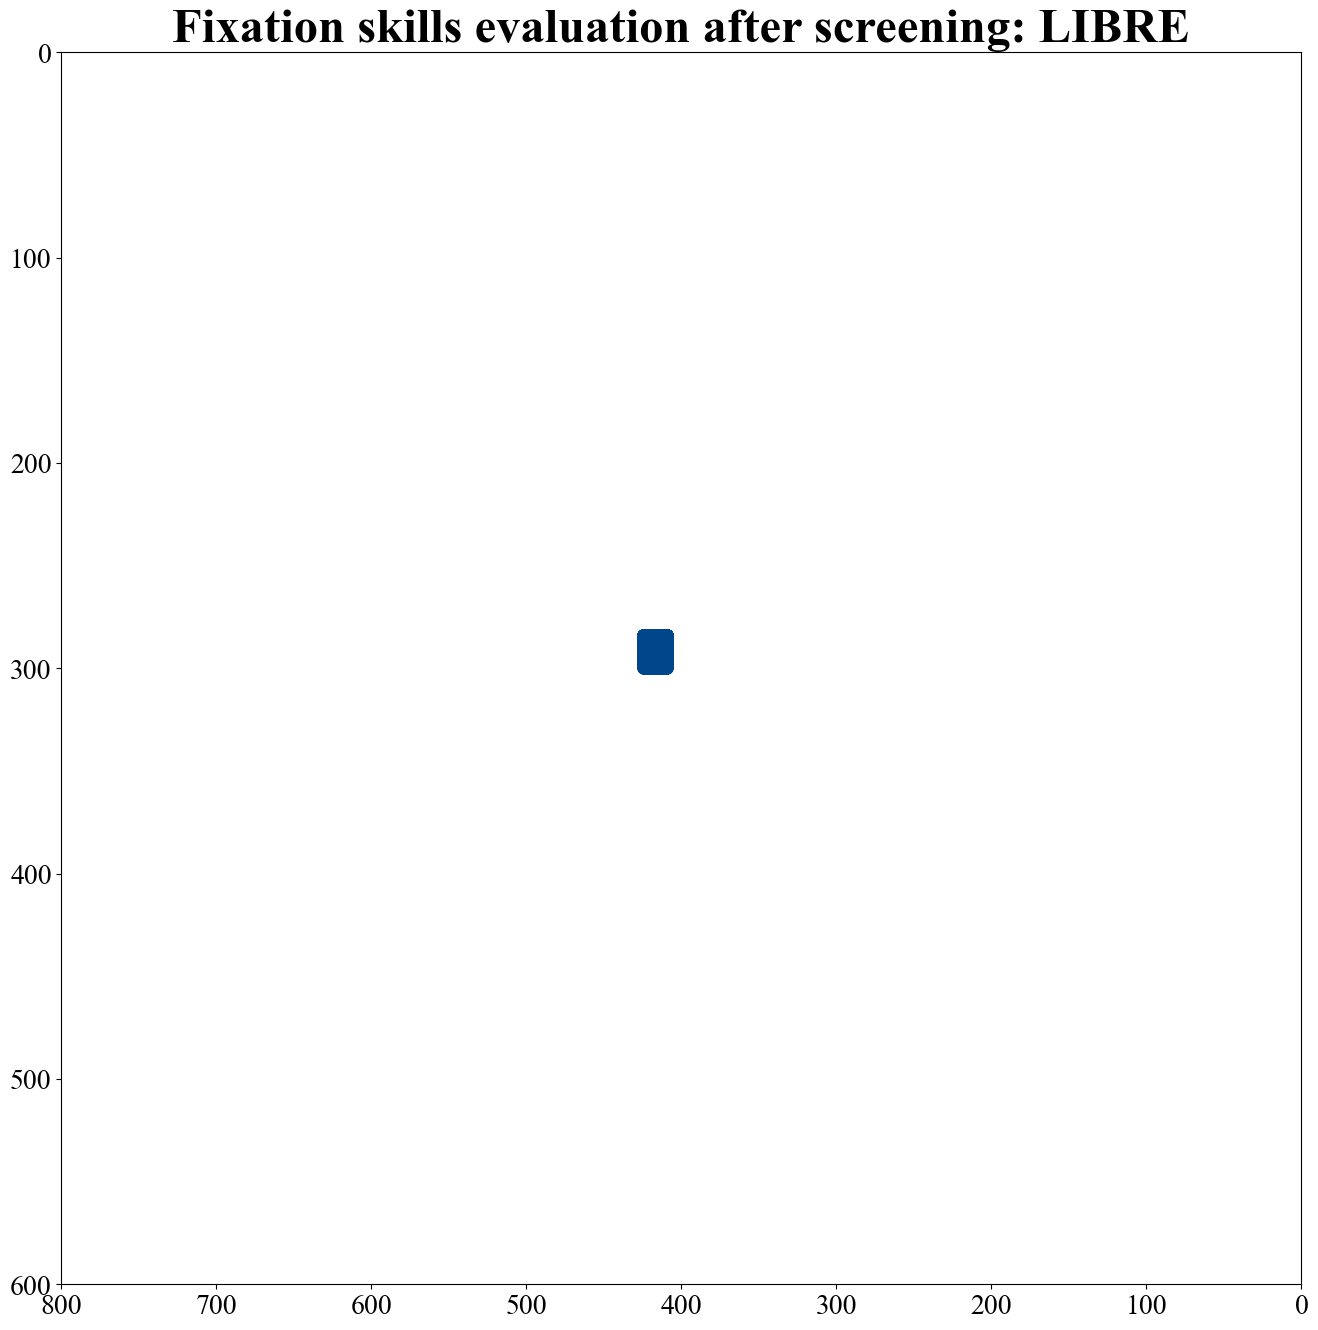

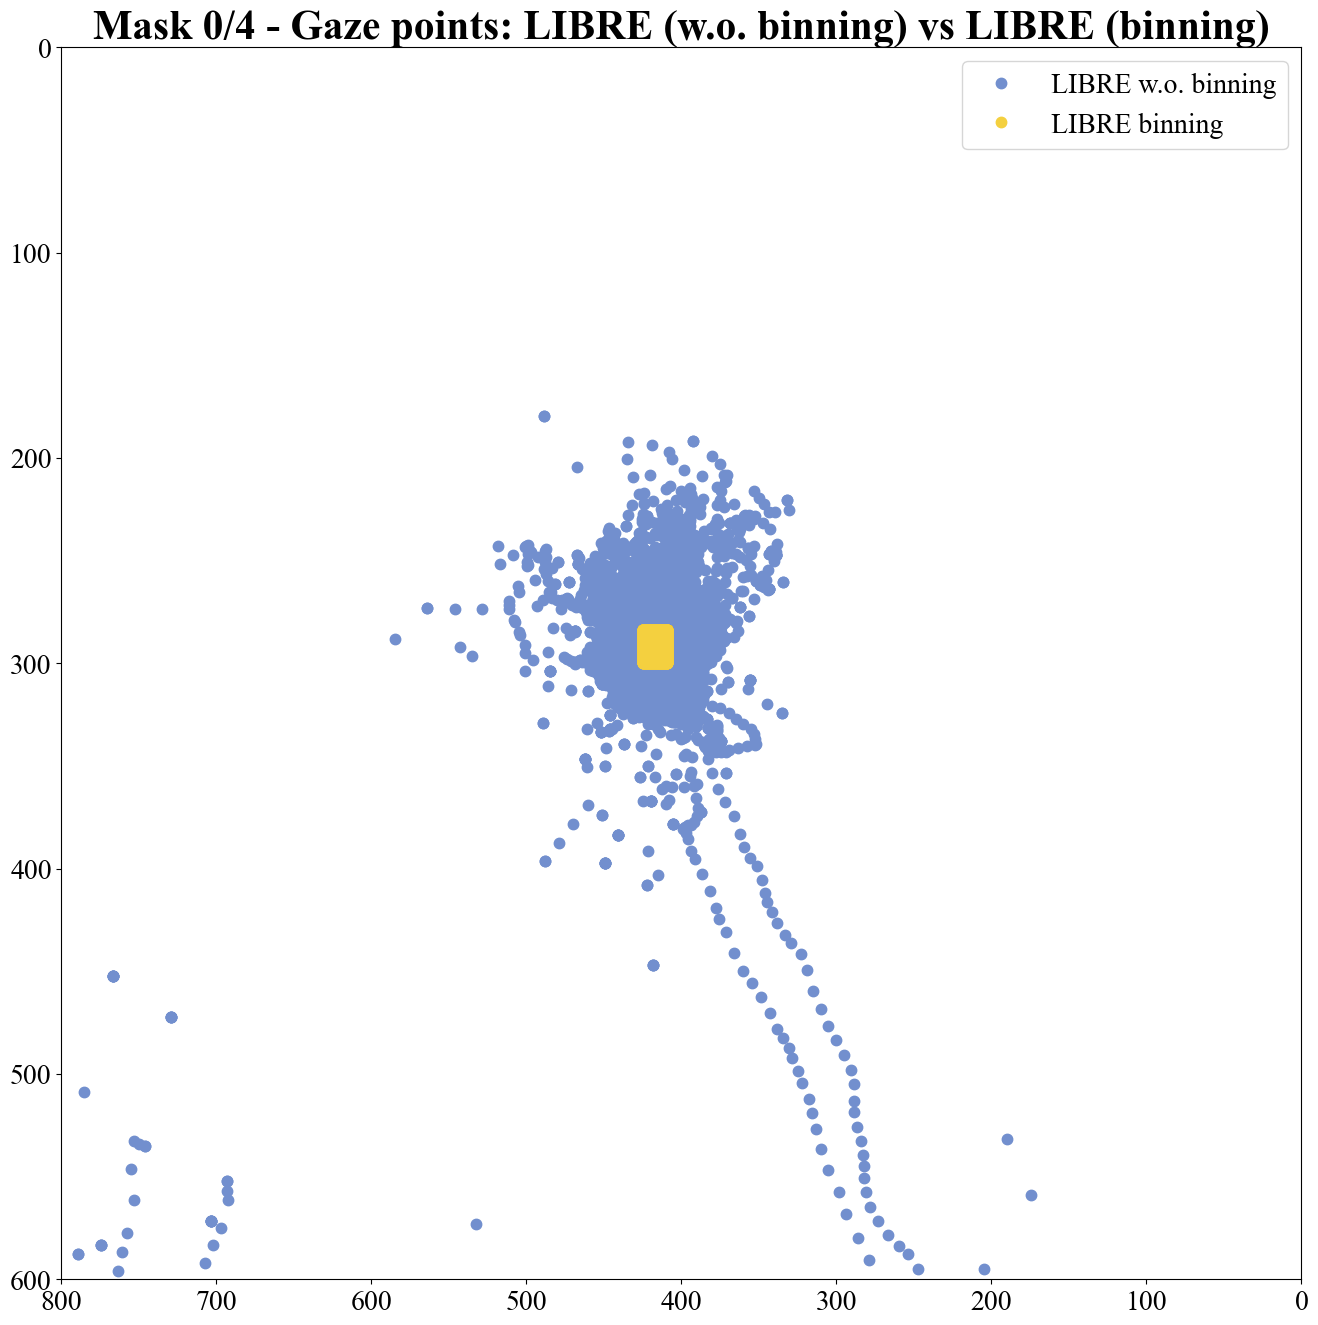

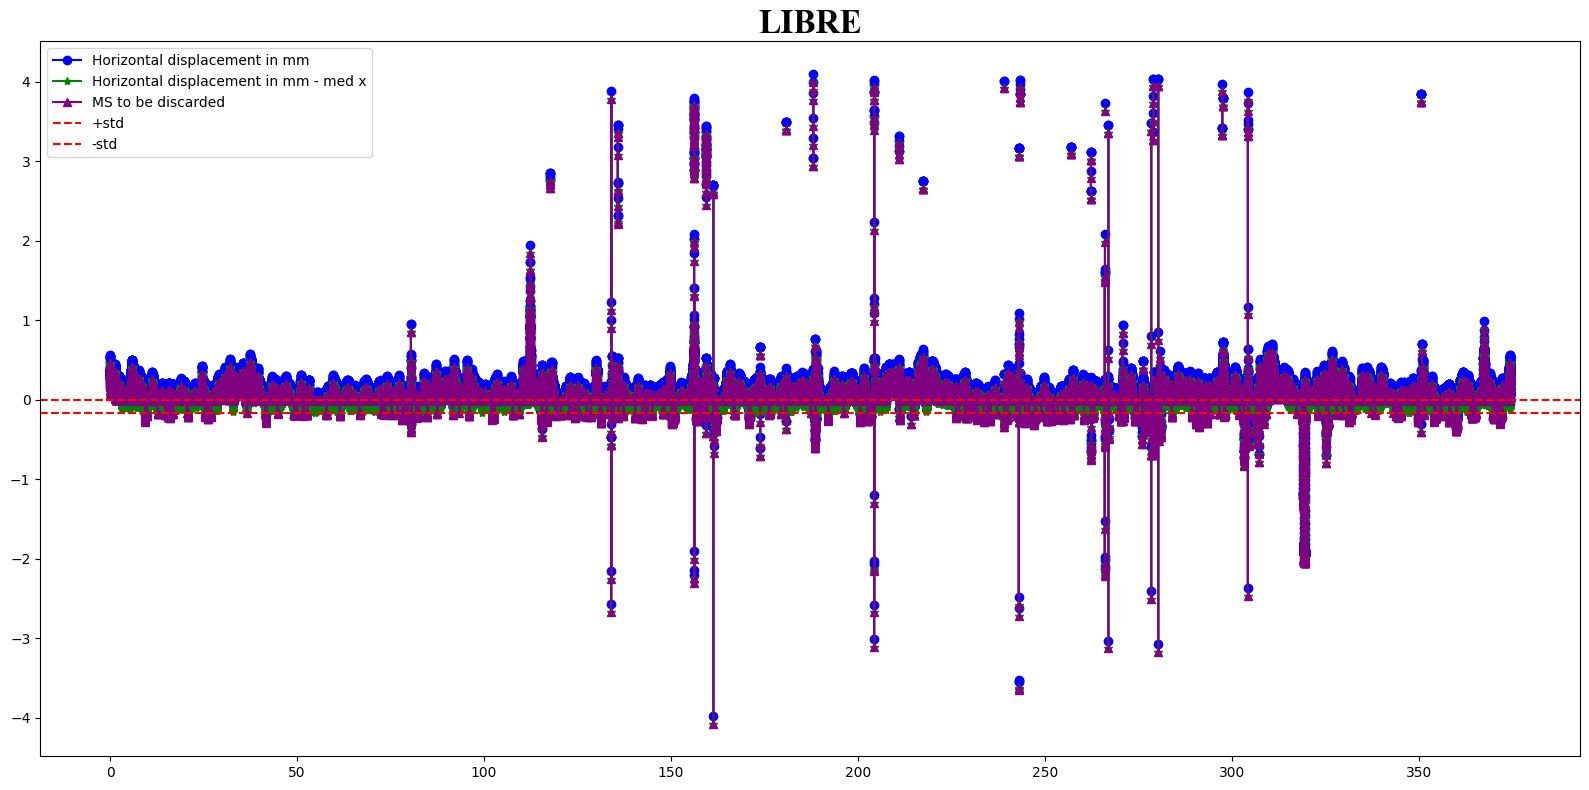

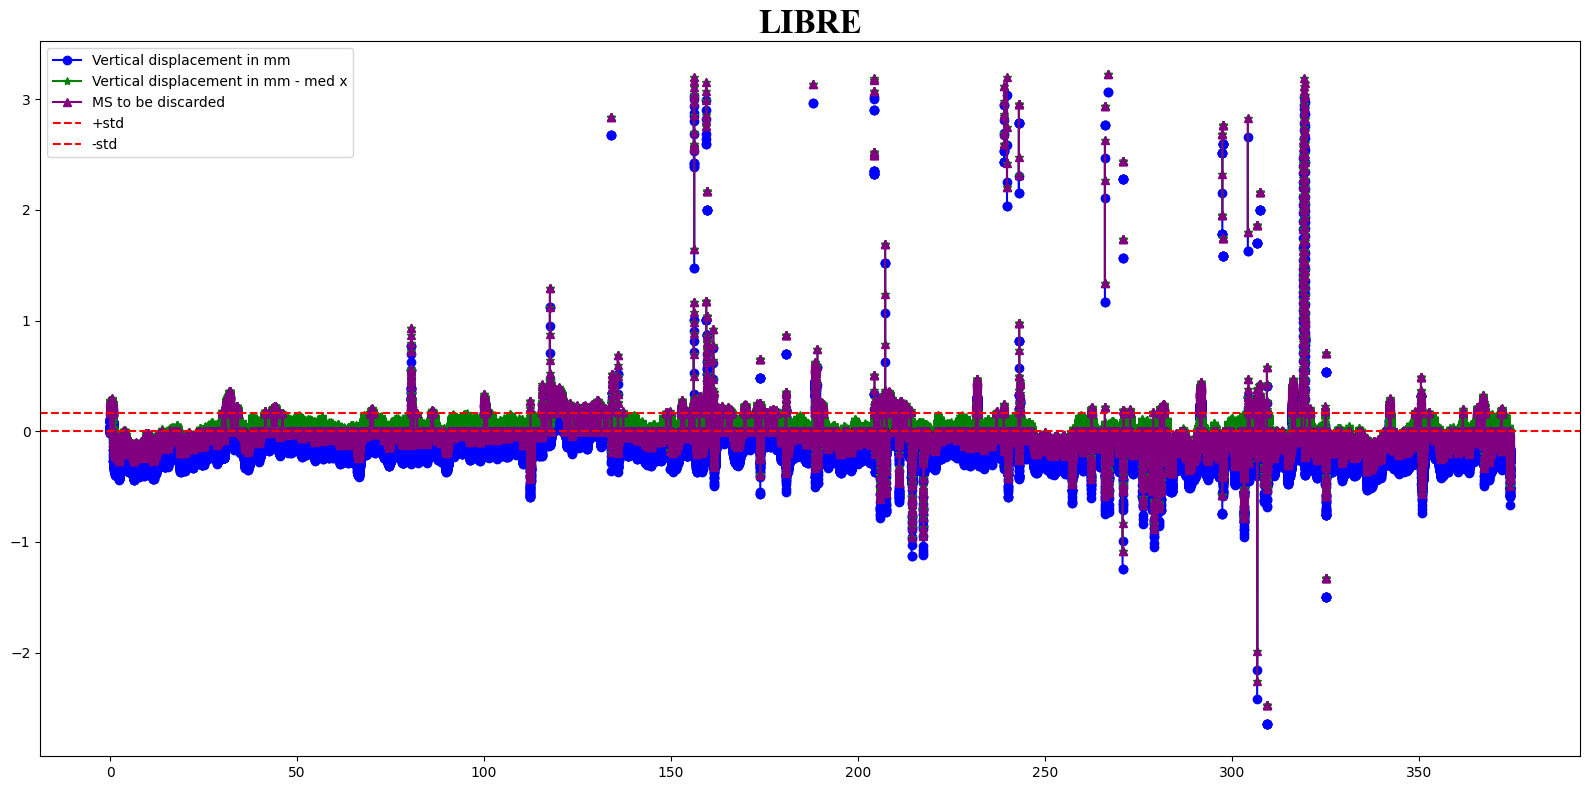

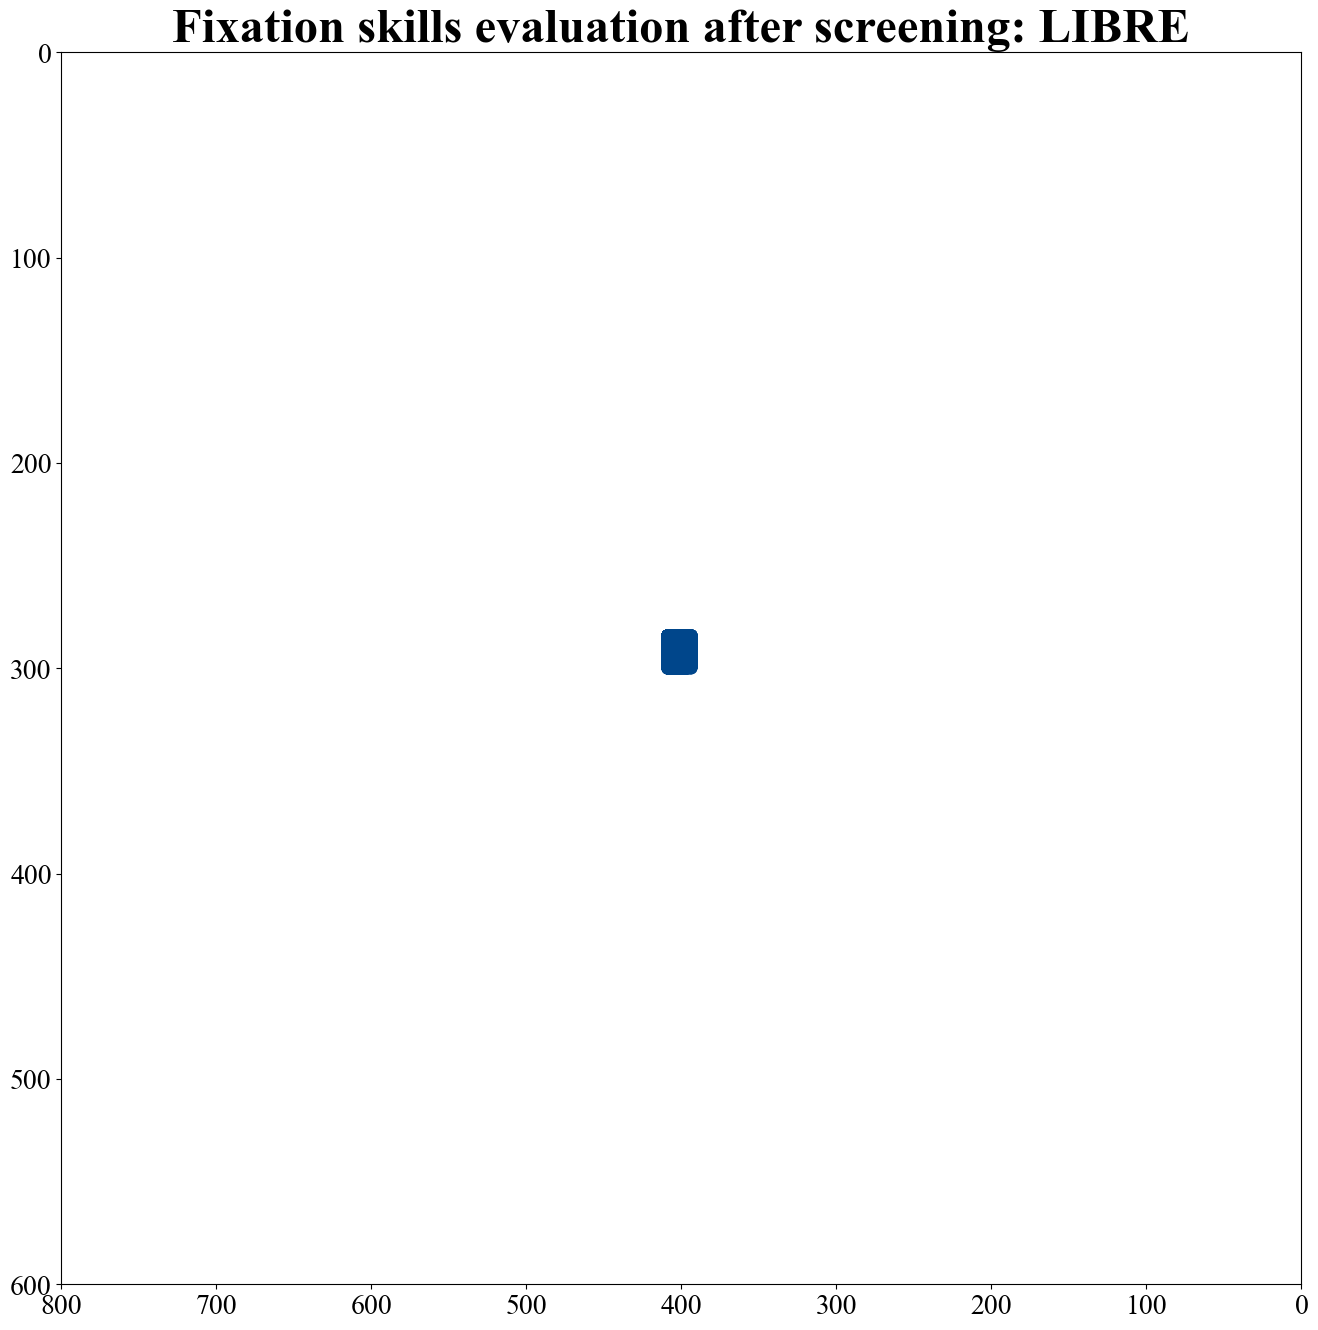

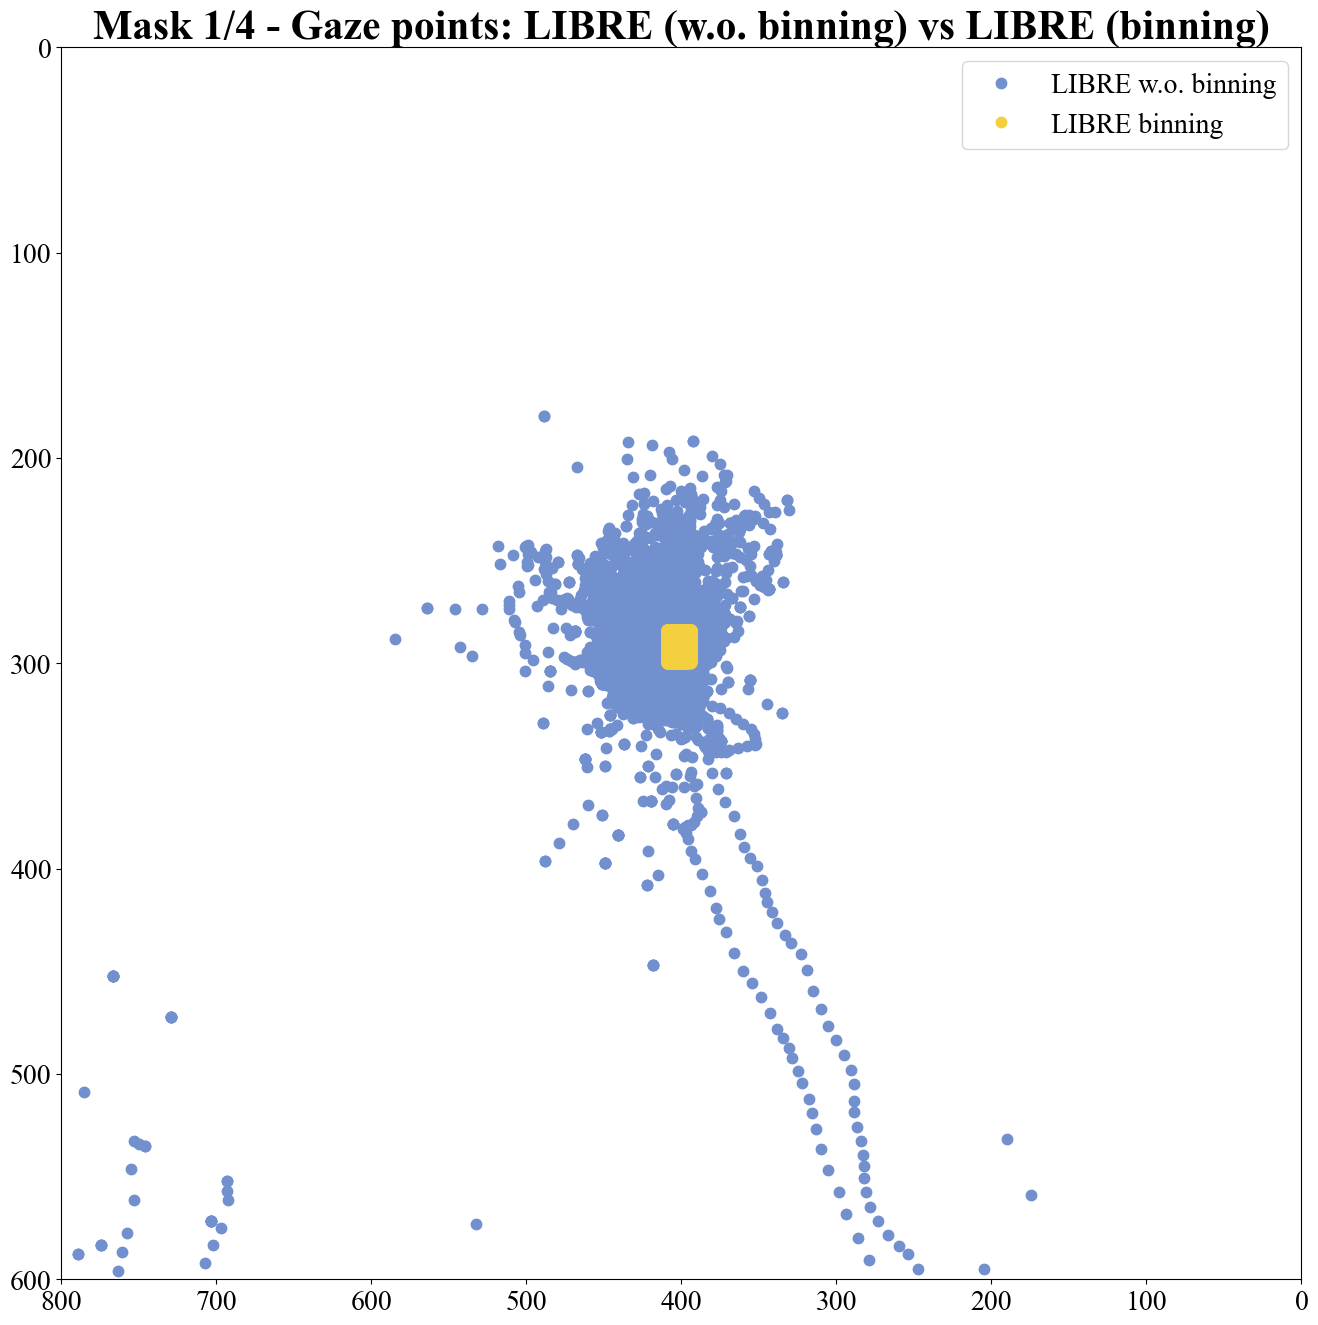

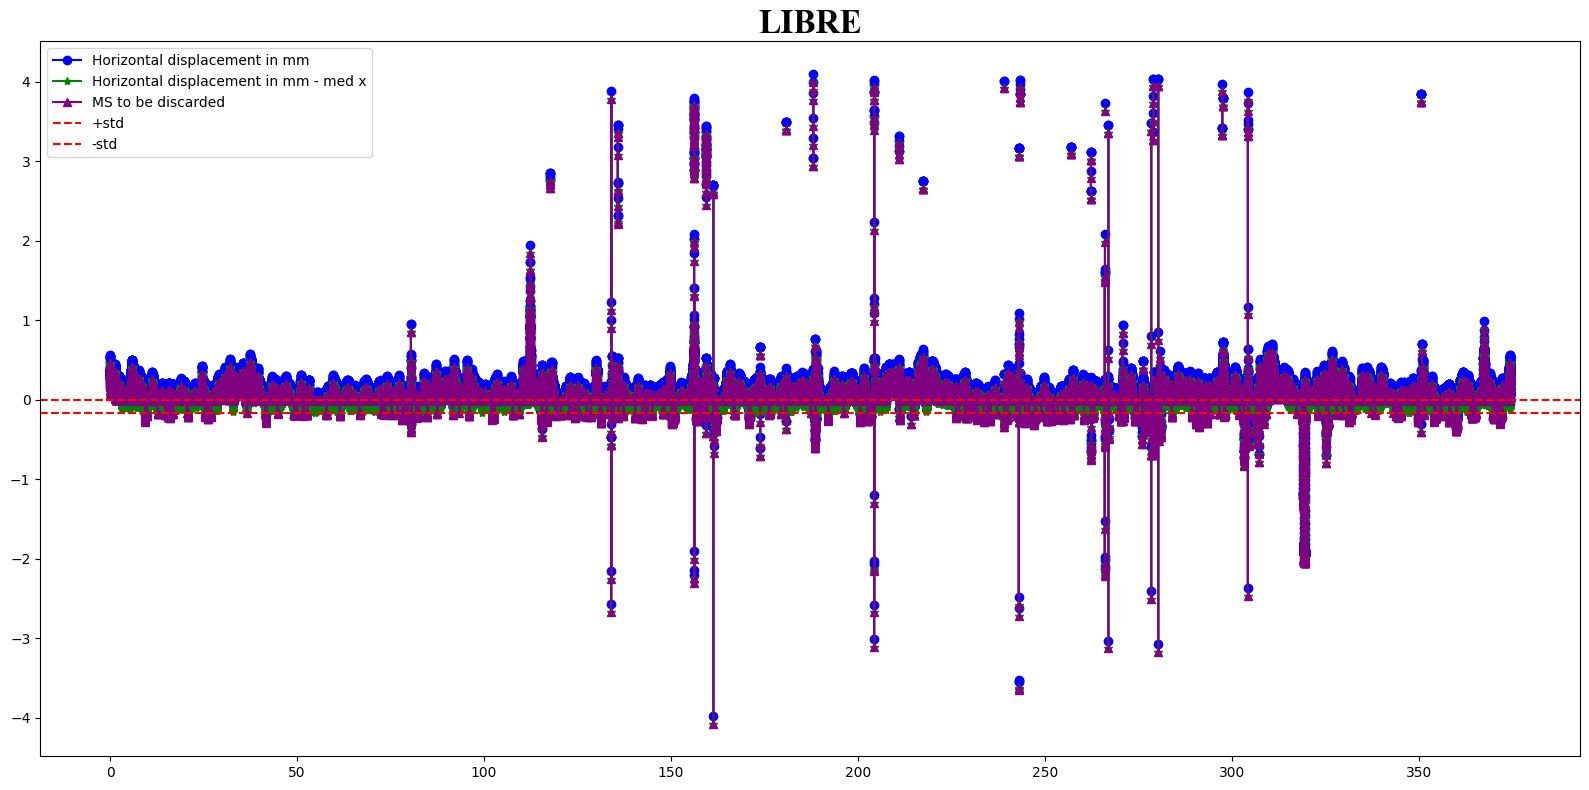

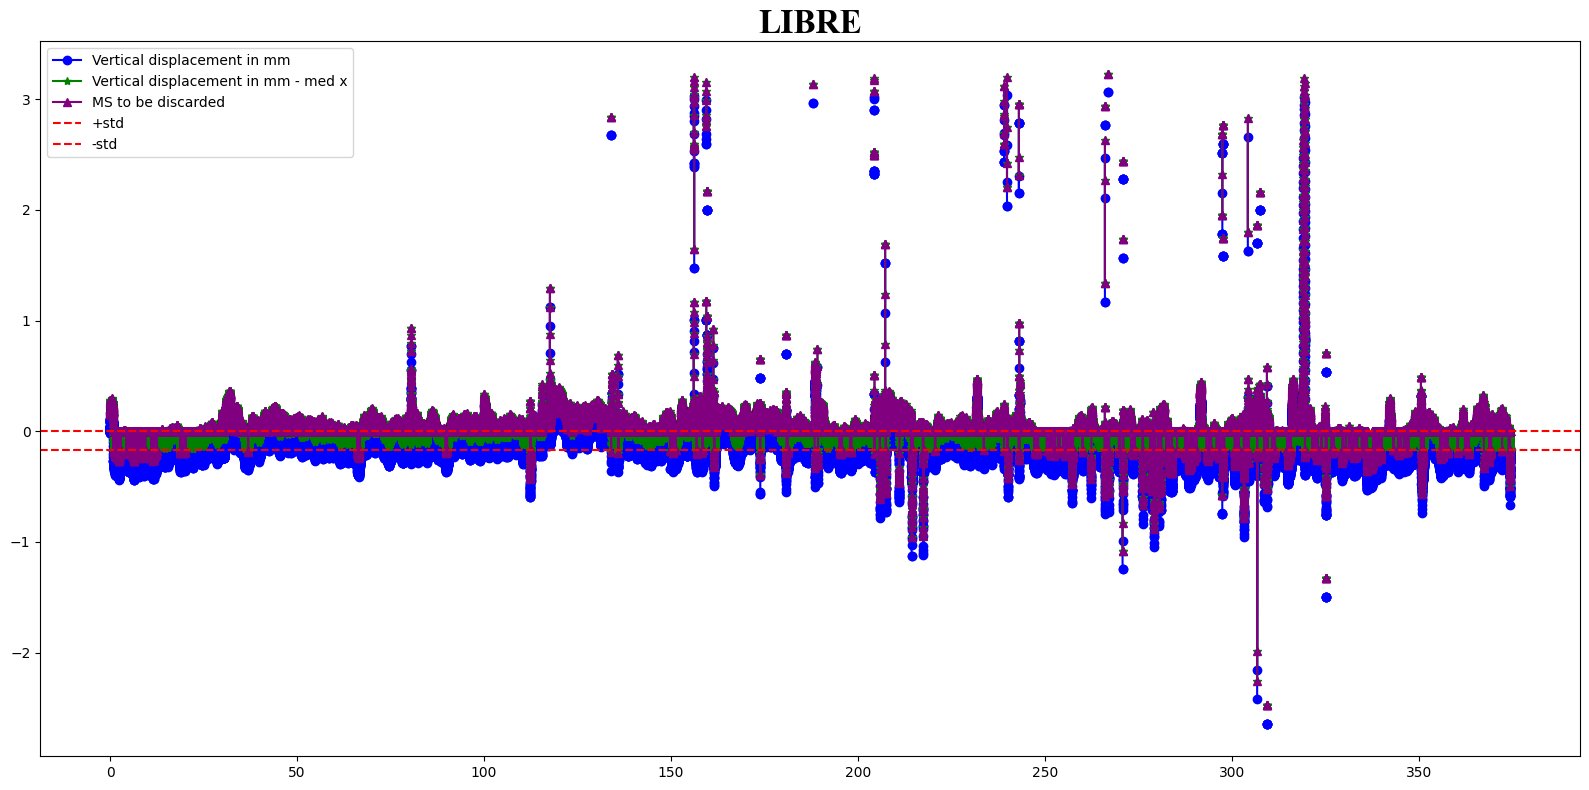

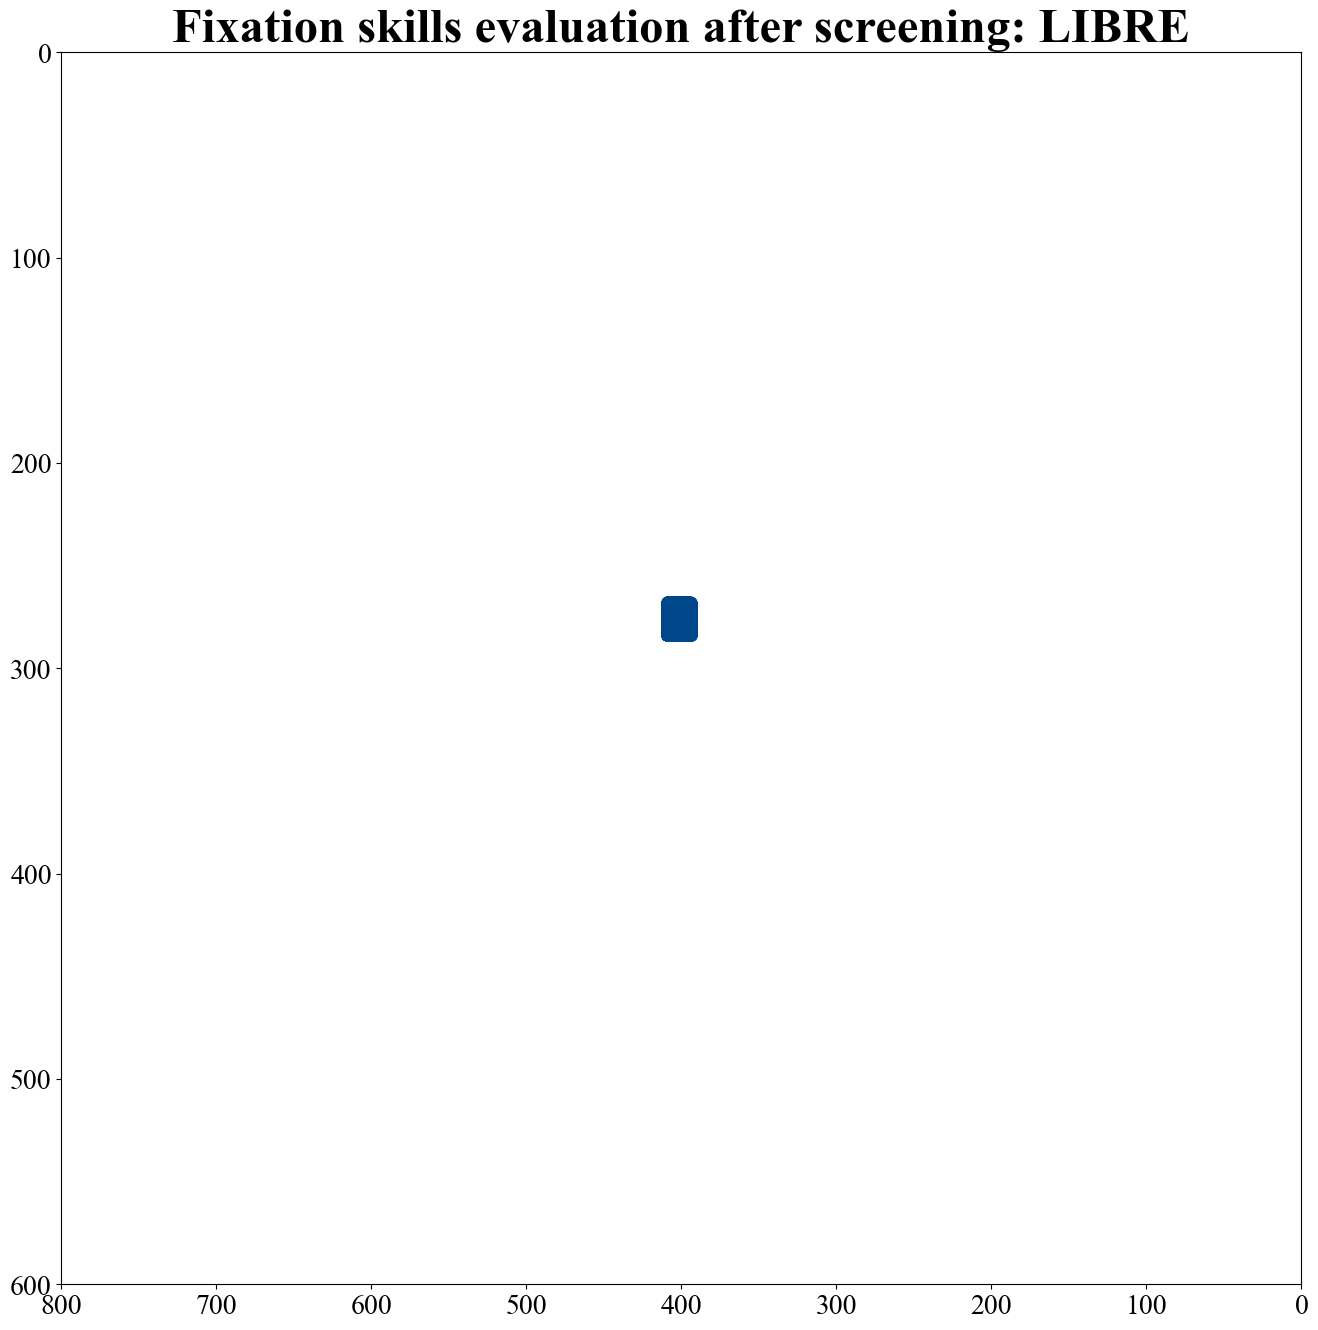

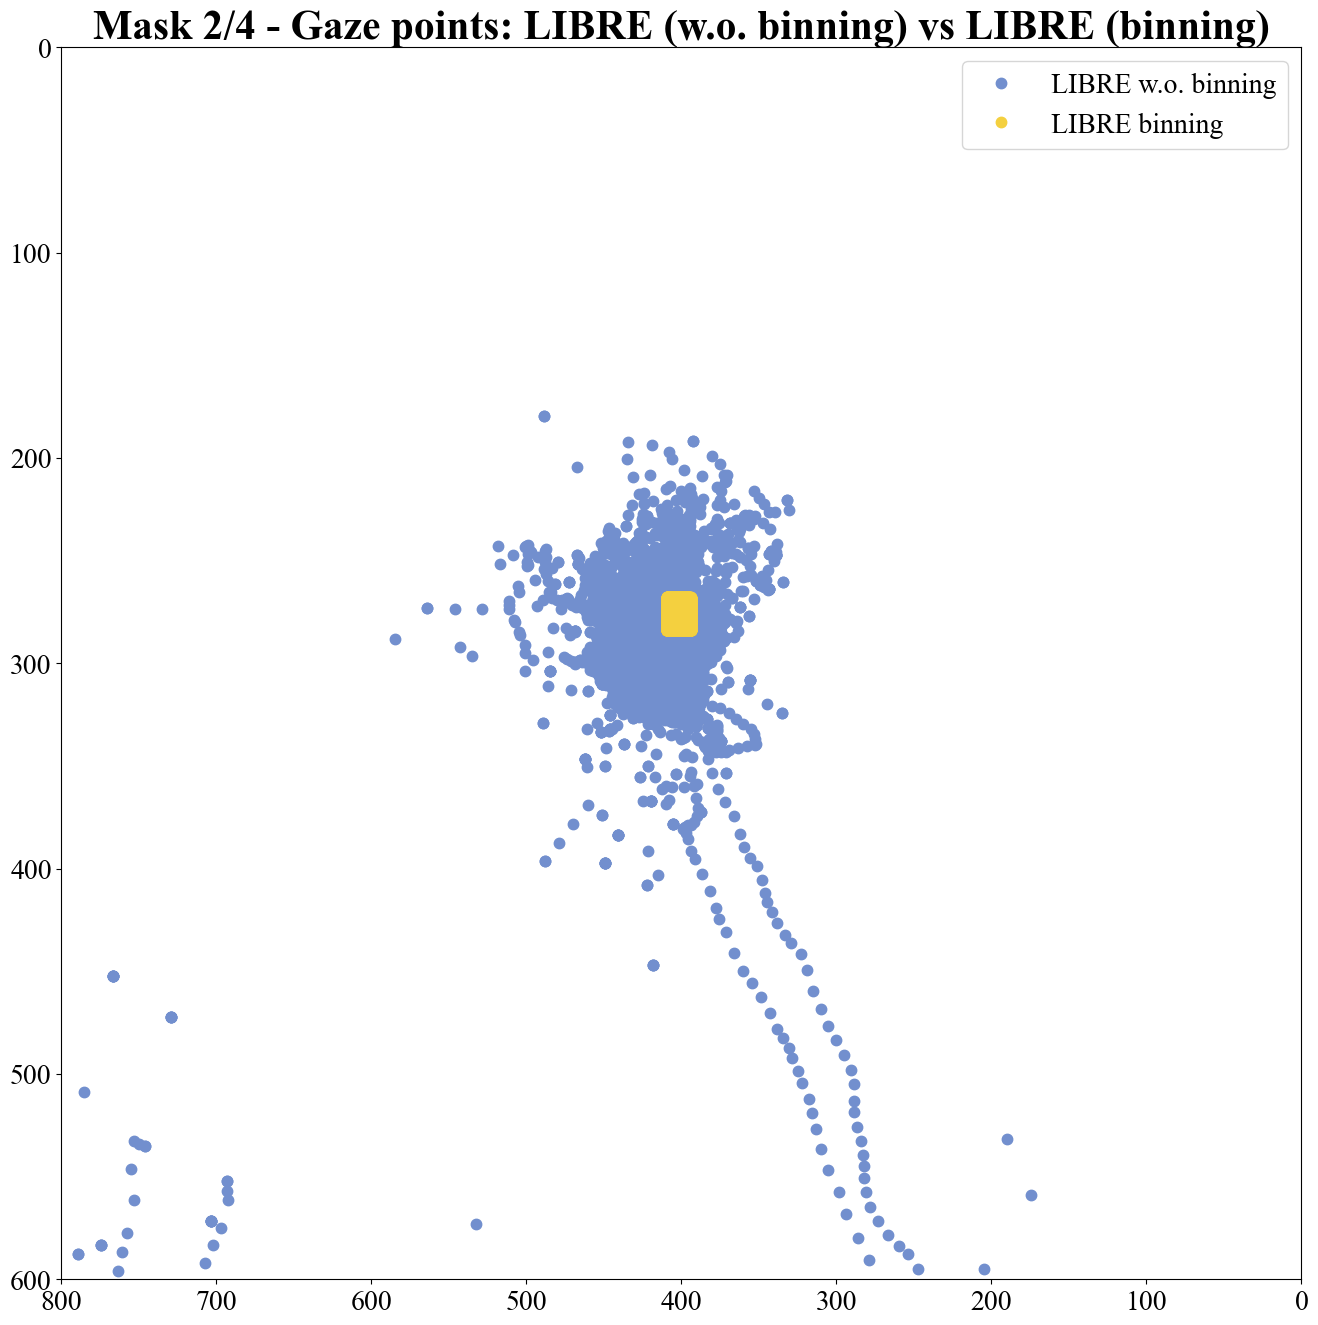

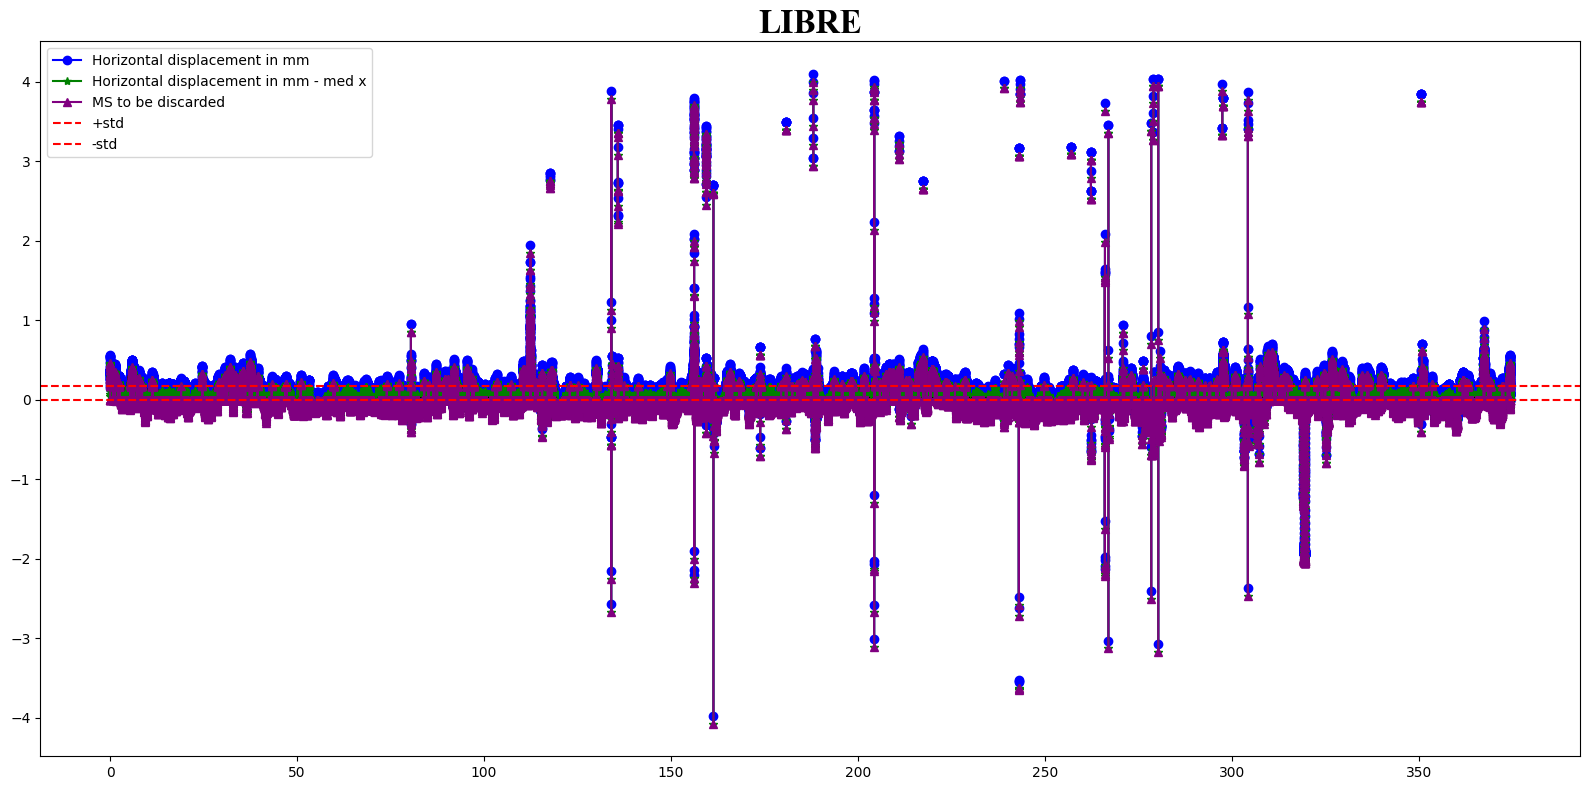

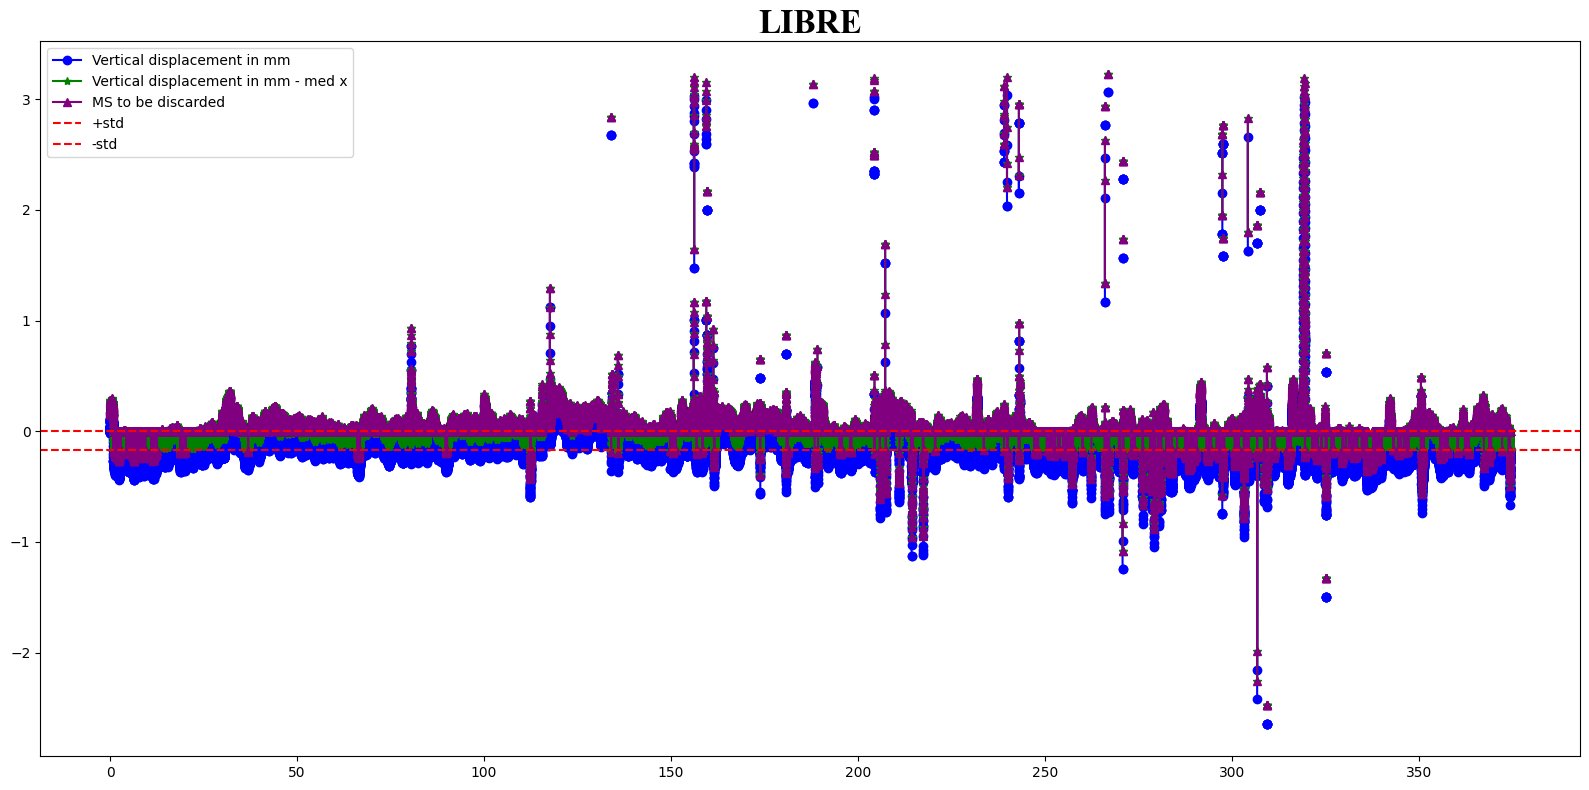

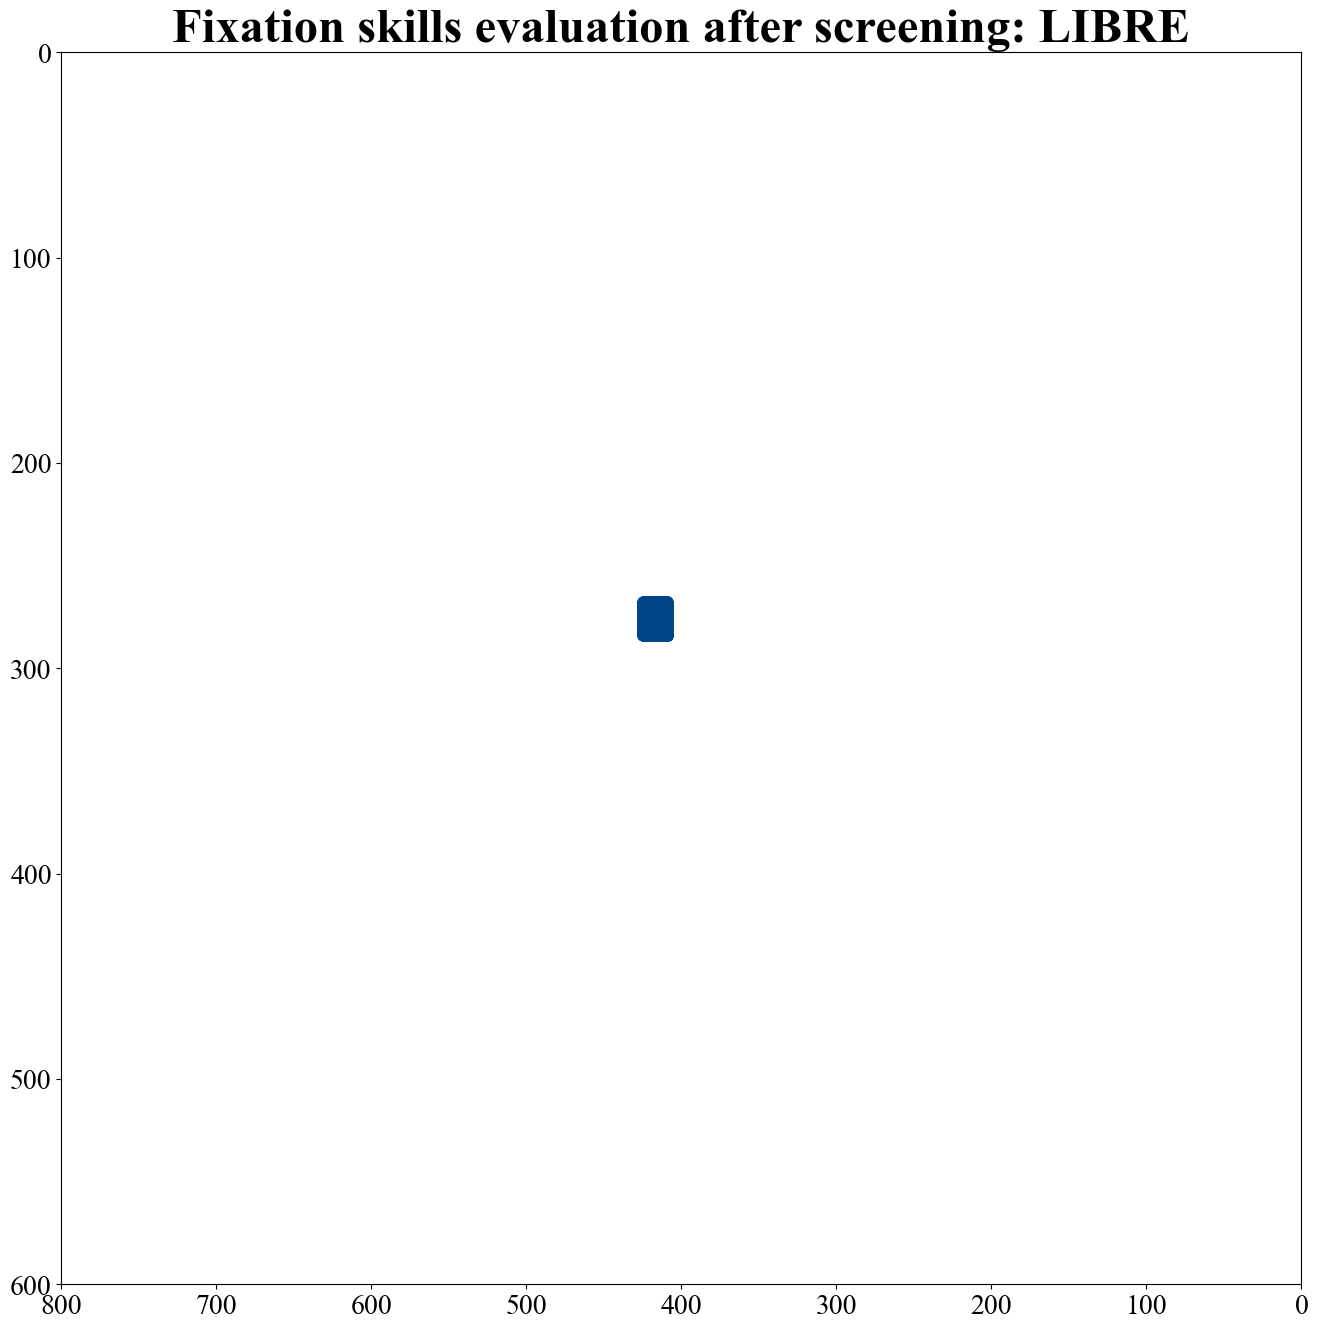

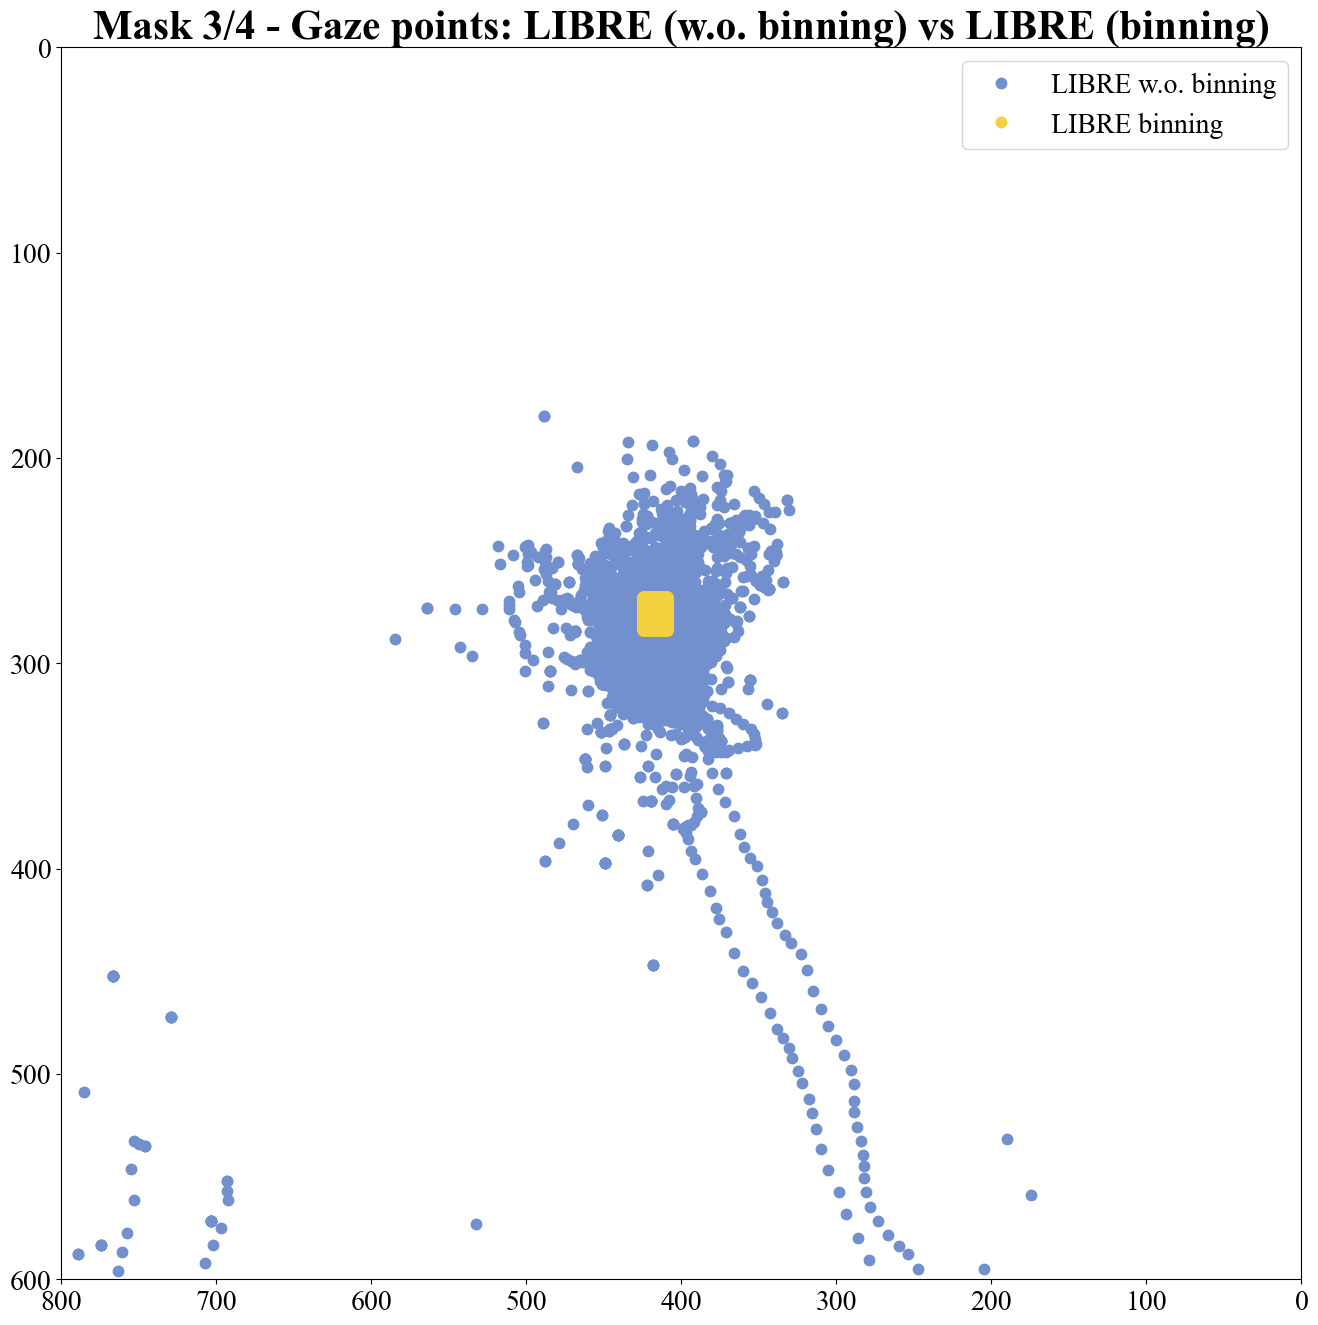

In [268]:
mask_num = 4
x_upper_list = [0.5*(1/3),  0,         0,          0.5*(1/3)]
x_lower_list = [0,         -0.5*(1/3), -0.5*(1/3), 0]
y_upper_list = [0.5*(1/3), 0.5*(1/3), 0,           0]
y_lower_list = [0,          0,         -0.5*(1/3), -0.5*(1/3)]

for idx in range(mask_num):
    coor_data_LIBRE_copy = copy.deepcopy(coor_data_LIBRE)
    Disp_dict_LIBRE = cal_disp(coor_data_LIBRE_copy, stand_x_upper=x_upper_list[idx], stand_x_lower=x_lower_list[idx], 
                               stand_y_upper=y_upper_list[idx], stand_y_lower=y_lower_list[idx])
    plot_x_y_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
    filtered_coor_data_LIBRE, Preserve_mask, _ = filter_XY_coord(coor_data_LIBRE_copy, Disp_dict_LIBRE, 'LIBRE')
    visualization_func(fig_title=f'Mask {idx}/{mask_num} - Gaze points: LIBRE (w.o. binning) vs LIBRE (binning)',
                      filtered_coor_data_LIBRE=filtered_coor_data_LIBRE)

    count_true = np.sum(Preserve_mask)
    print(count_true)
    # Save the Preserve_mask
    import os
    import scipy.io as sio

    mask_name = f'{FILE_NAME}_mask_meth2_0_33_{mask_num}_{idx}.mat'
    if subject_idx == 1:
        SAVE_PATH = Path("C:\\yiwei\\240912_recon\\Sub001\\T1_LIBRE_Binning\\BinningEYE_meas_MID00453_FID57919_BEAT_LIBREon_eye")
    elif subject_idx == 2:
        SAVE_PATH = Path("C:\\yiwei\\240912_recon\\Sub002\\T1_LIBRE_Binning\\BinningEYE_meas_MID00342_FID56821_BEAT_LIBREon_eye")


    # Create the folder if it doesn't exist
    os.makedirs(SAVE_PATH, exist_ok=True)
    mask_file = SAVE_PATH / mask_name

    # Save array to a .mat file
    sio.savemat(mask_file, {'array': Preserve_mask})
    print(f'The mask file has been saved here: {mask_file}')
    coor_data_LIBRE_copy = []


In [269]:
print(f'Sum of 4 masks of Sub001: {65153+70827+85580+64235}')
print(f'Sum of 4 masks of Sub002: {67540+77969+82277+68959}')


Sum of 4 masks of Sub001: 285795
Sum of 4 masks of Sub002: 296745


#### Method 3

In [184]:
def cal_radius(coor_data, stand_r=0.15):
    Disp_dict = {}
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    print(f'X_coord {X_coord}')
    print(f'Y_coord {Y_coord}')
    print('After cleaning nan, eminating data affected by blinking,\
            and preserving the fixation ')
    print(f'The length of X coordinate data: {len(X_coord)}')
    print(f'The length of Y coordinate data: {len(Y_coord)}')

    # Distance head-coil projector 102 cm  - size of an emmetrope eye varies from 2.1 cm to 2.7 cm 
    # (eye with a perfect vision)
    # in mm - this is common to both horizontal and angular rotation. 24 is 2.4cm which is the size of eye
    Cat1 =  24 + 1020
    print('check here is the eye size is defined manually?  can we extract the info from metadata?')

    # Depends on projector resolution, where 176px corresponds to 81.3 mm; 
    # so the formula becomes (Recorded_traj_px - center in px)*81.3/176
    # computation measures in mm， convert from px to mm
    # Transfer from pixel domain to mm, and shift the displacement to the center of screen
    Cat2_hor = np.where(np.isnan(X_coord), np.nan, abs(X_coord - 400) * 81.3 / 176)
    Cat2_ver = np.where(np.isnan(Y_coord), np.nan, abs(Y_coord - 300) * 62 / 137)
    
    Hor_rot = np.where(np.isnan(Cat2_hor), np.nan, np.arctan(Cat2_hor / Cat1))
    Ver_rot = np.where(np.isnan(Cat2_ver), np.nan, np.arctan(Cat2_ver / Cat1))

    Disp_mm_eye_x =  np.tan(Hor_rot)*12 # 12: radius of the eye
    Disp_mm_eye_y =  np.tan(Ver_rot)*12
    
    # Create a mask for np.nan values
    nan_mask = np.isnan(Disp_mm_eye_x) | np.isnan(Disp_mm_eye_y)

    # Calculate Disp_radius while handling np.nan
    Disp_radius = np.where(
        nan_mask,
        np.nan,  # If either Disp_mm_eye_x or Disp_mm_eye_y is nan, set Disp_radius to nan
        np.sqrt(Disp_mm_eye_x ** 2 + Disp_mm_eye_y ** 2)  # Otherwise, compute the radius
    )
    
    Disp_dict['Disp_mm_eye'] = (Disp_mm_eye_x, Disp_mm_eye_y)
    Disp_dict['Disp_radius'] = Disp_radius

    med_x = np.nanmedian(Disp_radius)
    print(f'med_x {med_x}')
    med_y = np.nanmedian(Disp_mm_eye_y)
    print(f'med_y {med_y}')
    Disp_dict['Disp_med'] = (med_x, med_y)
    
    med_r = np.nanmedian(Disp_radius)
    Disp_dict['Disp_med_r'] = med_r
  
    # 0.5*std(Disp_mm_eye_y);

    # Subtract median
    Disp_mm_eye_x_minus_mx = Disp_mm_eye_x - med_x
    Disp_mm_eye_y_minus_my = Disp_mm_eye_y - med_y
    Disp_mm_eye_r_minus_mr = Disp_radius - med_r
    
    Disp_dict['Disp_mm_eye_minus_med'] = (Disp_mm_eye_x_minus_mx, Disp_mm_eye_y_minus_my)
    Disp_dict['Disp_mm_eye_r_minus_mr'] = Disp_mm_eye_r_minus_mr
    print(f'Disp_mm_eye_r_minus_mr {Disp_mm_eye_r_minus_mr}')
    Ms_to_be_discarded_r_mask = (Disp_mm_eye_r_minus_mr > stand_r)|np.isnan(Disp_mm_eye_r_minus_mr)

    Disp_dict['Ms_to_be_discarded_mask'] = Ms_to_be_discarded_r_mask
    Disp_dict['stand_r'] = stand_r
    
    return Disp_dict


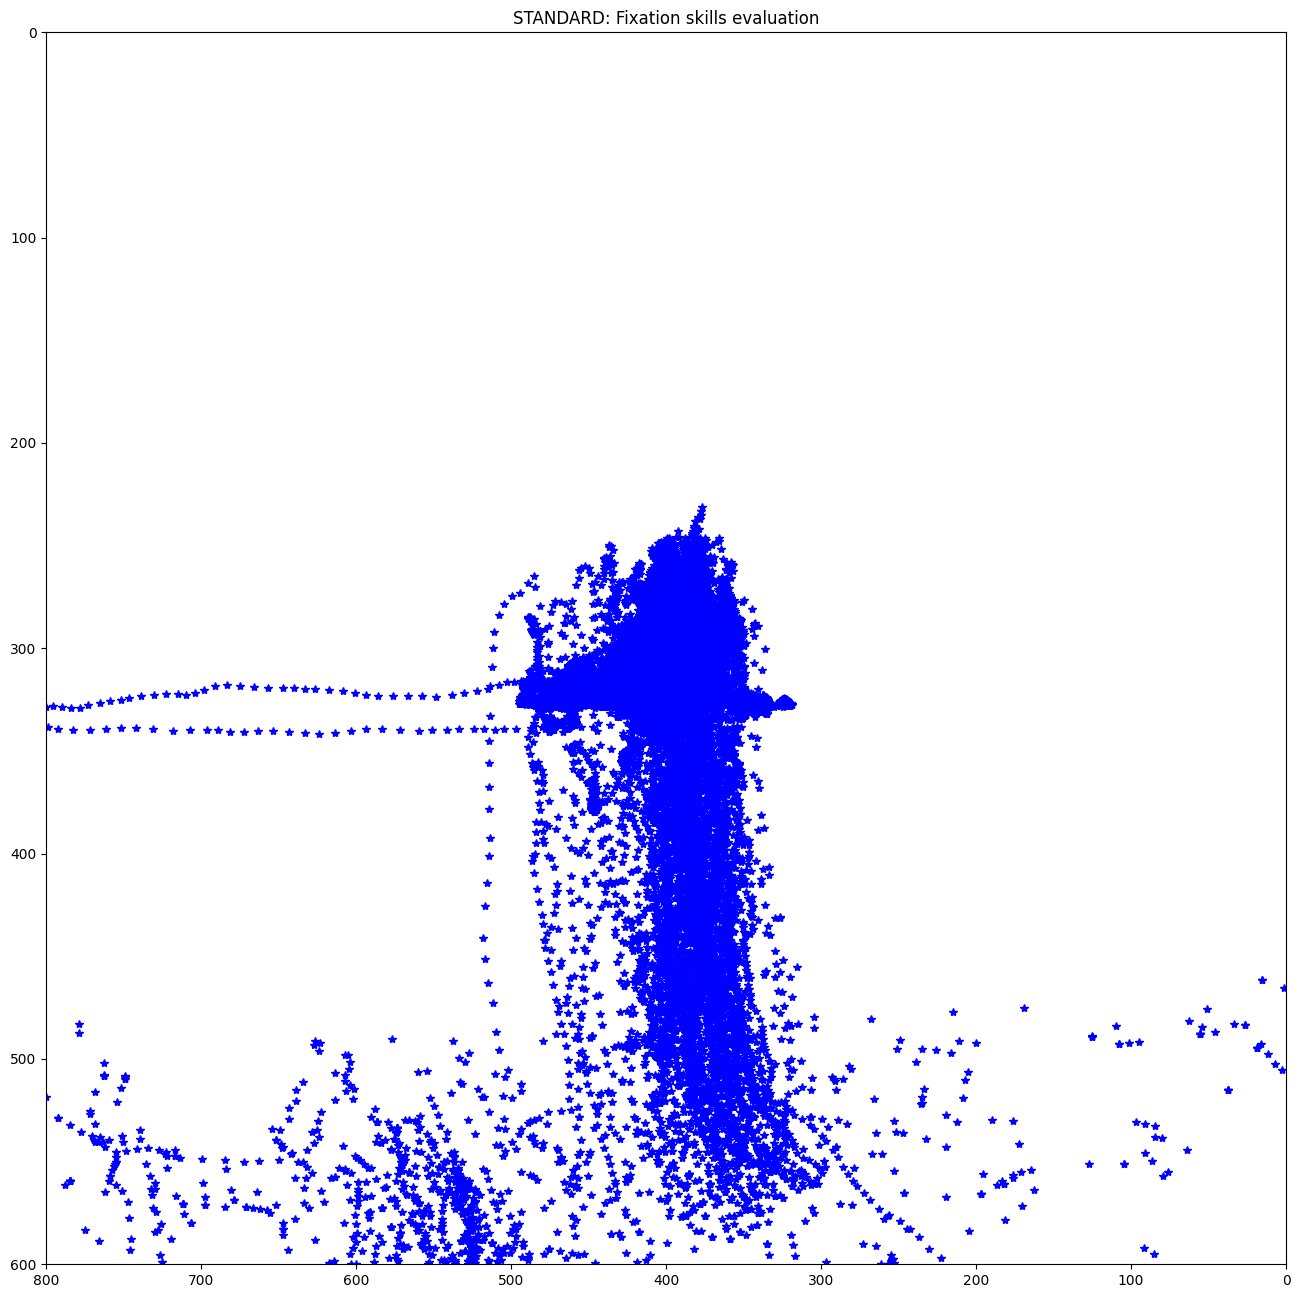

In [185]:
def filter_r_coord(coor_data, Disp_dict, seq_name=None):
#     x y coordinate accordingly
    X_coord = coor_data["x_coordinate"].values
    Y_coord = coor_data["y_coordinate"].values
    Ms_to_be_discarded_r_mask = Disp_dict['Ms_to_be_discarded_mask']
    
    Preserve_mask = ~(Ms_to_be_discarded_r_mask)

    filtered_X_coord = X_coord * Preserve_mask
    filtered_Y_coord = Y_coord * Preserve_mask

    zero_mask = (filtered_X_coord == 0) & (filtered_Y_coord == 0)
    filtered_X_coord[zero_mask] = np.nan
    filtered_Y_coord[zero_mask] = np.nan

    # Example data (replace with your actual data)
    fig, ax= plt.subplots(figsize=(16, 16))
    # Plot the data, flipping X coordinates and using dots as markers
    plt.plot(filtered_X_coord, filtered_Y_coord, '*', color='blue')
    plt.xlim(0, 800)
    plt.ylim((0, 600))
    # Set plot title
    if seq_name is not None:
        plt.title(f'Fixation skills evaluation after screening: {seq_name}')
    else:     
        plt.title('Fixation skills evaluation after screening')

    # Reverse the direction of the Y-axis
    plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    
    coor_data["x_coordinate"] = filtered_X_coord
    coor_data["y_coordinate"] = filtered_Y_coord
    
    return coor_data, Preserve_mask
    

# Example data (replace with your actual data)
X_coord = coor_data_STANDARD['x_coordinate']
Y_coord = coor_data_STANDARD['y_coordinate']
fig, ax= plt.subplots(figsize=(16, 16))
# Plot the data, flipping X coordinates and using dots as markers
plt.plot(X_coord, Y_coord, '*', color='blue')
plt.xlim((0, 800))
plt.ylim((0, 600))
# Set plot title
plt.title('STANDARD: Fixation skills evaluation')
# Reverse the direction of the Y-axis
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [186]:
def plot_r_coord(Disp_dict, metadata, duration=None, start_sample=0, seq_name=None):
    Disp_mm_eye_x = Disp_dict['Disp_mm_eye'][0]
    Disp_mm_eye_y = Disp_dict['Disp_mm_eye'][1]
    Disp_radius = Disp_dict['Disp_radius']
    
    Disp_mm_eye_x_minus_mx = Disp_dict['Disp_mm_eye_minus_med'][0]
    Disp_mm_eye_y_minus_my = Disp_dict['Disp_mm_eye_minus_med'][1]
    Disp_mm_eye_r_minus_mr = Disp_dict['Disp_mm_eye_r_minus_mr']
    
    
    Ms_to_be_discarded_r_mask = Disp_dict['Ms_to_be_discarded_mask']
    stand_r = Disp_dict['stand_r']
    
    if duration == None:
        end_sample = len(Disp_mm_eye_x)
    else:    
        end_sample = duration*metadata["SamplingFrequency"]

    t_axis_xy = np.arange(start_sample, end_sample, 1)/metadata["SamplingFrequency"]

    # radius direction!!!!!
    fig, ax= plt.subplots(figsize=(16, 8))
    
    ax.plot(
        t_axis_xy,
        Disp_radius[start_sample:end_sample],
        marker='o', color='blue',
        label="Radial displacement in mm"
    )
    ax.plot(
        t_axis_xy,
        Disp_mm_eye_r_minus_mr[start_sample:end_sample],
        marker='*', color='green',
        label='Radial displacement in mm - med r'
    )

    if len(Ms_to_be_discarded_r_mask) != 0:
        ax.plot(
            t_axis_xy,
            Disp_mm_eye_r_minus_mr[start_sample:end_sample] * Ms_to_be_discarded_r_mask[start_sample:end_sample],
            marker='^', color='purple',
            label= 'MS to be discarded'
        )
    ax.axhline(y=Disp_dict['stand_r'], color='r', linestyle='--', label='+std')
    ax.axhline(y=-Disp_dict['stand_r'], color='r', linestyle='--', label='-std')
    ax.legend()
    ax.set_title(seq_name)
    plt.tight_layout()



X_coord [         nan          nan          nan ... 398.29998779 398.1000061
 398.1000061 ]
Y_coord [         nan          nan          nan ... 305.20001221 303.1000061
 300.8999939 ]
After cleaning nan, eminating data affected by blinking,            and preserving the fixation 
The length of X coordinate data: 362000
The length of Y coordinate data: 362000
check here is the eye size is defined manually?  can we extract the info from metadata?
med_x 0.06692429486183482
med_y 0.03277114213978207
Disp_mm_eye_r_minus_mr [        nan         nan         nan ... -0.03840869 -0.04790316
 -0.05580281]


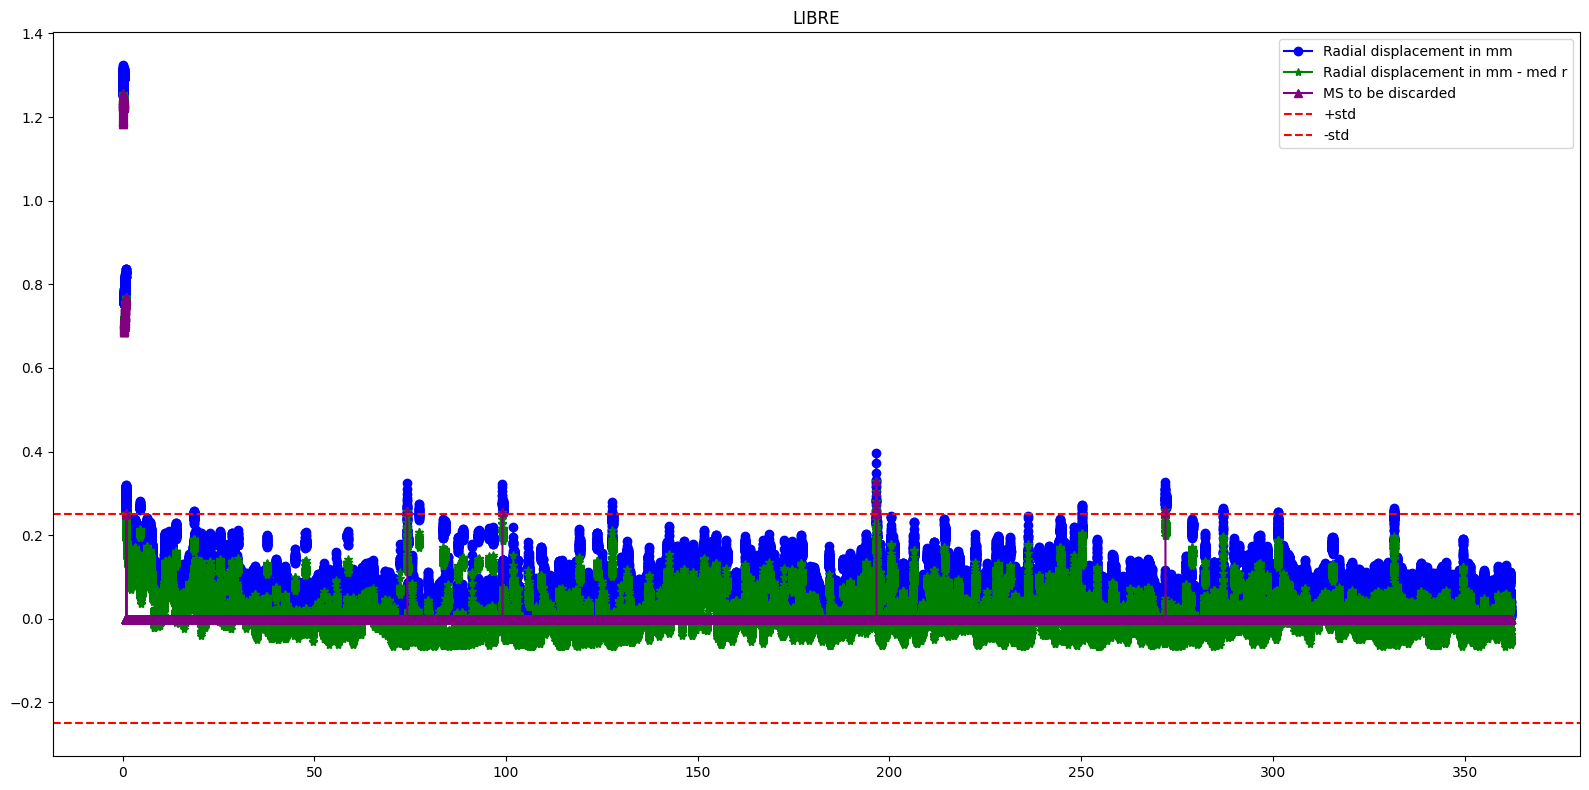

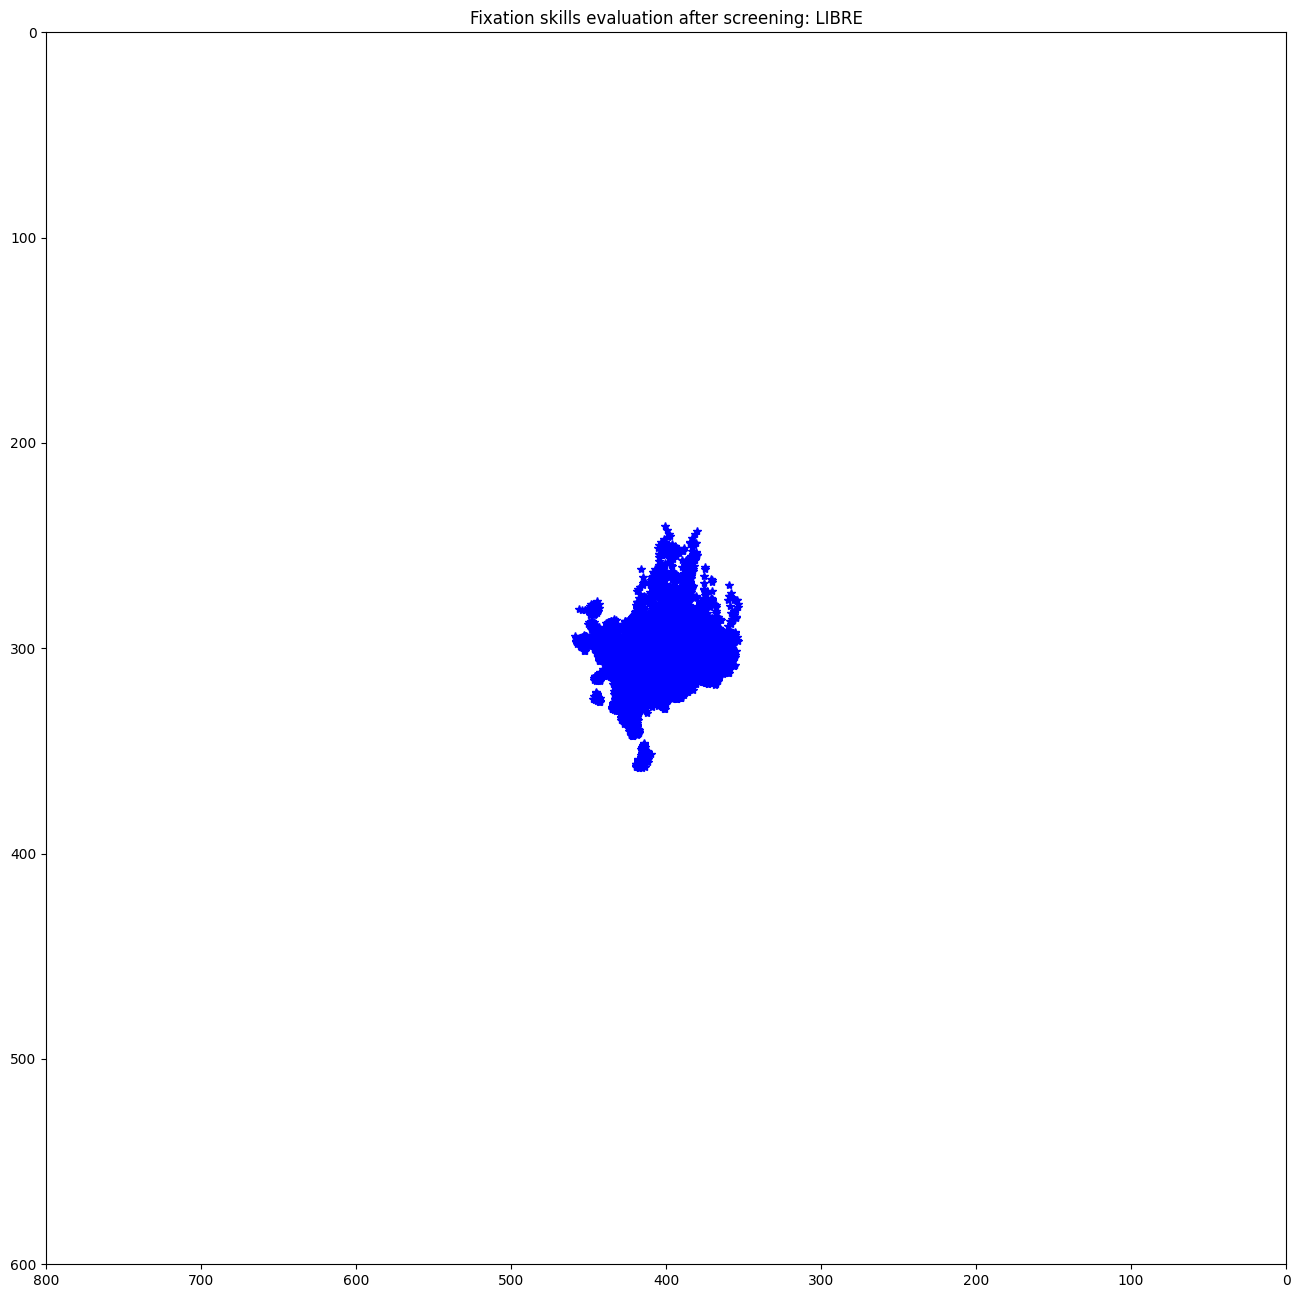

In [187]:
coor_data_LIBRE_4 = copy.deepcopy(coor_data_LIBRE)
Disp_dict_LIBRE = cal_radius(coor_data_LIBRE_4, stand_r=0.5*(1/2))
plot_r_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
filtered_coor_data_LIBRE, Preserve_mask = filter_r_coord(coor_data_LIBRE_4, Disp_dict_LIBRE, 'LIBRE')

# coor_data_LIBRE_5 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_radius(coor_data_LIBRE_5, stand_r=0.5*(1/3))
# plot_r_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_r_coord(coor_data_LIBRE_5, Disp_dict_LIBRE, 'LIBRE')

# coor_data_LIBRE_6 = copy.deepcopy(coor_data_LIBRE)
# Disp_dict_LIBRE = cal_radius(coor_data_LIBRE_6, stand_r=0.5*(1/4))
# plot_r_coord(Disp_dict_LIBRE, metadata, duration=None, start_sample=0, seq_name='LIBRE')
# filtered_coor_data_LIBRE = filter_r_coord(coor_data_LIBRE_6, Disp_dict_LIBRE, 'LIBRE')

# plot_x_y_coord(Disp_dict_STANDARD, metadata, duration=None, start_sample=0, seq_name='STANDARD')

In [190]:
count_discard = np.sum(Disp_dict_LIBRE['Ms_to_be_discarded_mask'])
count_discard

16728